The one below is pretrained on Zulu dataset for sentiment analysis, XLM not frozen.

In [ ]:
"""
AfroXLMR Sentiment Analysis - TRAINING CODE
Fine-tune AfroXLMR on Zulu sentiment data and save the model
"""

# ============================================================================
# Step 0: Install and Import Dependencies
# ============================================================================
print("="*80)
print("📦 INSTALLING DEPENDENCIES")
print("="*80)

!pip install -q transformers torch scikit-learn matplotlib seaborn pandas numpy datasets accelerate

import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully!")

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
print()

# ============================================================================
# Configuration
# ============================================================================
class Config:
    MODEL_NAME = "Davlan/afro-xlmr-base"
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EPOCHS = 5
    WARMUP_STEPS = 100
    WEIGHT_DECAY = 0.01
    SEED = 42
    SAVE_DIR = "./afroxlmr_zulu_sentiment"

    # Label mappings
    ID2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}
    LABEL2ID = {'negative': 0, 'neutral': 1, 'positive': 2}
    NUM_LABELS = 3

# Set random seeds
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

print("="*80)
print("🎓 TRAINING AFROXLMR ON ZULU SENTIMENT DATA")
print("="*80)
print()

# ============================================================================
# Step 1: Load Dataset
# ============================================================================
print("="*80)
print("📂 LOADING ZULU DATASET")
print("="*80)

print("Please upload your Zulu sentiment dataset (.csv file):")
uploaded = files.upload()

zulu_filename = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {zulu_filename}")

# Load data
df = pd.read_csv(zulu_filename)
print(f"Loaded: {len(df)} examples")
print(f"Columns: {list(df.columns)}")

# Standardize columns
if 'Zulu' in df.columns:
    df = df.rename(columns={'Zulu': 'text'})
if 'new_sentiment' in df.columns:
    df = df.rename(columns={'new_sentiment': 'label'})

# Standardize labels
def standardize_label(label):
    label = str(label).strip().lower()
    if 'neg' in label:
        return 0
    elif 'neu' in label:
        return 1
    elif 'pos' in label:
        return 2
    else:
        return 1

df['label'] = df['label'].apply(standardize_label)

print("\nLabel distribution:")
for label_id in sorted(df['label'].unique()):
    count = (df['label'] == label_id).sum()
    pct = count / len(df) * 100
    print(f"  {Config.ID2LABEL[label_id].capitalize():8s}: {count:4d} ({pct:5.2f}%)")
print()

# ============================================================================
# Step 2: Split Dataset
# ============================================================================
print("="*80)
print("✂️  SPLITTING DATASET")
print("="*80)

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=Config.SEED,
    stratify=df['label']
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.125,  # 0.125 * 0.8 = 0.1 of total
    random_state=Config.SEED,
    stratify=train_df['label']
)

print(f"Training set:   {len(train_df)} examples")
print(f"Validation set: {len(val_df)} examples")
print(f"Test set:       {len(test_df)} examples")
print()

# ============================================================================
# Step 3: Prepare Datasets
# ============================================================================
print("="*80)
print("🔧 PREPARING DATASETS")
print("="*80)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=Config.MAX_LENGTH
    )

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

print("✅ Datasets tokenized and ready")
print()

# ============================================================================
# Step 4: Load Model
# ============================================================================
print("="*80)
print("🤖 LOADING MODEL")
print("="*80)

model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=Config.NUM_LABELS,
    id2label=Config.ID2LABEL,
    label2id=Config.LABEL2ID
)

model.to(device)
print(f"✅ Model loaded: {Config.MODEL_NAME}")
print()

# ============================================================================
# Step 5: Training Setup
# ============================================================================
print("="*80)
print("⚙️  TRAINING CONFIGURATION")
print("="*80)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir=Config.SAVE_DIR,
    num_train_epochs=Config.EPOCHS,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    warmup_steps=Config.WARMUP_STEPS,
    weight_decay=Config.WEIGHT_DECAY,
    learning_rate=Config.LEARNING_RATE,
    logging_dir=f'{Config.SAVE_DIR}/logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Training configuration:")
print(f"  Epochs: {Config.EPOCHS}")
print(f"  Batch size: {Config.BATCH_SIZE}")
print(f"  Learning rate: {Config.LEARNING_RATE}")
print(f"  Max length: {Config.MAX_LENGTH}")
print()

# ============================================================================
# Step 6: Train Model
# ============================================================================
print("="*80)
print("🚀 STARTING TRAINING")
print("="*80)
print()

trainer.train()

print("\n✅ Training completed!")
print()

# ============================================================================
# Step 7: Evaluate on Test Set
# ============================================================================
print("="*80)
print("📊 EVALUATING ON TEST SET")
print("="*80)
print()

test_results = trainer.evaluate(test_dataset)

print("Test Set Results:")
print(f"  Accuracy:  {test_results['eval_accuracy']:.4f} ({test_results['eval_accuracy']*100:.2f}%)")
print(f"  F1-Score:  {test_results['eval_f1']:.4f} ({test_results['eval_f1']*100:.2f}%)")
print(f"  Precision: {test_results['eval_precision']:.4f} ({test_results['eval_precision']*100:.2f}%)")
print(f"  Recall:    {test_results['eval_recall']:.4f} ({test_results['eval_recall']*100:.2f}%)")
print()

# ============================================================================
# Step 8: Save Model
# ============================================================================
print("="*80)
print("💾 SAVING MODEL")
print("="*80)

# Save model and tokenizer
trainer.save_model(Config.SAVE_DIR)
tokenizer.save_pretrained(Config.SAVE_DIR)

print(f"✅ Model saved to: {Config.SAVE_DIR}")
print()

# Also save test set for zero-shot comparison
test_df.to_csv(f"{Config.SAVE_DIR}/test_set.csv", index=False)
print(f"✅ Test set saved to: {Config.SAVE_DIR}/test_set.csv")
print()

# Save configuration
import json
config_dict = {
    'model_name': Config.MODEL_NAME,
    'max_length': Config.MAX_LENGTH,
    'num_labels': Config.NUM_LABELS,
    'id2label': Config.ID2LABEL,
    'label2id': Config.LABEL2ID,
    'test_accuracy': test_results['eval_accuracy'],
    'test_f1': test_results['eval_f1']
}

with open(f"{Config.SAVE_DIR}/config.json", 'w') as f:
    json.dump(config_dict, f, indent=2)

print("✅ Configuration saved")
print()

print("="*80)
print("🎉 TRAINING COMPLETE!")
print("="*80)
print()
print("Next steps:")
print("1. Download the model folder using the Files panel")
print("2. Use the zero-shot evaluation code with this saved model")
print()

📦 INSTALLING DEPENDENCIES
✅ All packages imported successfully!
🖥️  Device: cuda
   GPU: NVIDIA A100-SXM4-40GB

🎓 TRAINING AFROXLMR ON ZULU SENTIMENT DATA

📂 LOADING ZULU DATASET
Please upload your Zulu sentiment dataset (.csv file):


Saving zulu_sentiment_balanced_NEW.csv to zulu_sentiment_balanced_NEW.csv

✅ Uploaded: zulu_sentiment_balanced_NEW.csv
Loaded: 1839 examples
Columns: ['Zulu', 'new_sentiment']

Label distribution:
  Negative:  613 (33.33%)
  Neutral :  613 (33.33%)
  Positive:  613 (33.33%)

✂️  SPLITTING DATASET
Training set:   1287 examples
Validation set: 184 examples
Test set:       368 examples

🔧 PREPARING DATASETS


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

✅ Datasets tokenized and ready

🤖 LOADING MODEL


config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded: Davlan/afro-xlmr-base

⚙️  TRAINING CONFIGURATION
Training configuration:
  Epochs: 5
  Batch size: 16
  Learning rate: 2e-05
  Max length: 128

🚀 STARTING TRAINING



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.100400,1.083648,0.380435,0.260441,0.574965,0.380435
2,0.917200,0.712812,0.684783,0.676029,0.683706,0.684783
3,0.701600,0.826274,0.635870,0.603954,0.690926,0.635870
4,0.442000,0.565125,0.766304,0.763639,0.763513,0.766304
5,0.353200,0.574504,0.798913,0.796755,0.796800,0.798913



✅ Training completed!

📊 EVALUATING ON TEST SET



Test Set Results:
  Accuracy:  0.7554 (75.54%)
  F1-Score:  0.7475 (74.75%)
  Precision: 0.7534 (75.34%)
  Recall:    0.7554 (75.54%)

💾 SAVING MODEL
✅ Model saved to: ./afroxlmr_zulu_sentiment

✅ Test set saved to: ./afroxlmr_zulu_sentiment/test_set.csv

✅ Configuration saved

🎉 TRAINING COMPLETE!

Next steps:
1. Download the model folder using the Files panel
2. Use the zero-shot evaluation code with this saved model



This is training the head only on Zulu dataset.

In [ ]:
"""
AfroXLMR Sentiment Analysis - TRAINING CODE
Fine-tune only the classifier head on Zulu sentiment data and save the model
"""

# ============================================================================
# Step 0: Install and Import Dependencies
# ============================================================================
print("="*80)
print("📦 INSTALLING DEPENDENCIES")
print("="*80)

!pip install -q transformers torch scikit-learn matplotlib seaborn pandas numpy datasets accelerate

import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully!")

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
print()

# ============================================================================
# Configuration
# ============================================================================
class Config:
    MODEL_NAME = "Davlan/afro-xlmr-base"
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EPOCHS = 5
    WARMUP_STEPS = 100
    WEIGHT_DECAY = 0.01
    SEED = 42
    SAVE_DIR = "./afroxlmr_zulu_sentiment_head_only"

    # Label mappings
    ID2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}
    LABEL2ID = {'negative': 0, 'neutral': 1, 'positive': 2}
    NUM_LABELS = 3

# Set random seeds
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

print("="*80)
print("🎓 TRAINING AFROXLMR (HEAD ONLY) ON ZULU SENTIMENT DATA")
print("="*80)
print()

# ============================================================================
# Step 1: Load Dataset
# ============================================================================
print("="*80)
print("📂 LOADING ZULU DATASET")
print("="*80)

print("Please upload your Zulu sentiment dataset (.csv file):")
uploaded = files.upload()

zulu_filename = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {zulu_filename}")

# Load data
df = pd.read_csv(zulu_filename)
print(f"Loaded: {len(df)} examples")
print(f"Columns: {list(df.columns)}")

# Standardize columns
if 'Zulu' in df.columns:
    df = df.rename(columns={'Zulu': 'text'})
if 'new_sentiment' in df.columns:
    df = df.rename(columns={'new_sentiment': 'label'})

# Standardize labels
def standardize_label(label):
    label = str(label).strip().lower()
    if 'neg' in label:
        return 0
    elif 'neu' in label:
        return 1
    elif 'pos' in label:
        return 2
    else:
        return 1

df['label'] = df['label'].apply(standardize_label)

print("\nLabel distribution:")
for label_id in sorted(df['label'].unique()):
    count = (df['label'] == label_id).sum()
    pct = count / len(df) * 100
    print(f"  {Config.ID2LABEL[label_id].capitalize():8s}: {count:4d} ({pct:5.2f}%)")
print()

# ============================================================================
# Step 2: Split Dataset
# ============================================================================
print("="*80)
print("✂️  SPLITTING DATASET")
print("="*80)

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=Config.SEED,
    stratify=df['label']
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.125,  # 0.125 * 0.8 = 0.1 of total
    random_state=Config.SEED,
    stratify=train_df['label']
)

print(f"Training set:   {len(train_df)} examples")
print(f"Validation set: {len(val_df)} examples")
print(f"Test set:       {len(test_df)} examples")
print()

# ============================================================================
# Step 3: Prepare Datasets
# ============================================================================
print("="*80)
print("🔧 PREPARING DATASETS")
print("="*80)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=Config.MAX_LENGTH
    )

# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

print("✅ Datasets tokenized and ready")
print()

# ============================================================================
# Step 4: Load Model
# ============================================================================
print("="*80)
print("🤖 LOADING MODEL")
print("="*80)

model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=Config.NUM_LABELS,
    id2label=Config.ID2LABEL,
    label2id=Config.LABEL2ID
)

# ------------------- FREEZE BASE MODEL -------------------
for param in model.base_model.parameters():
    param.requires_grad = False
print("✅ Base model frozen. Only classifier head will be trained.")
# ---------------------------------------------------------

model.to(device)
print(f"✅ Model loaded: {Config.MODEL_NAME}")
print()

# ============================================================================
# Step 5: Training Setup
# ============================================================================
print("="*80)
print("⚙️  TRAINING CONFIGURATION")
print("="*80)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir=Config.SAVE_DIR,
    num_train_epochs=Config.EPOCHS,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    warmup_steps=Config.WARMUP_STEPS,
    weight_decay=Config.WEIGHT_DECAY,
    learning_rate=Config.LEARNING_RATE,
    logging_dir=f'{Config.SAVE_DIR}/logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Training configuration:")
print(f"  Epochs: {Config.EPOCHS}")
print(f"  Batch size: {Config.BATCH_SIZE}")
print(f"  Learning rate: {Config.LEARNING_RATE}")
print(f"  Max length: {Config.MAX_LENGTH}")
print()

# ============================================================================
# Step 6: Train Model
# ============================================================================
print("="*80)
print("🚀 STARTING TRAINING")
print("="*80)
print()

trainer.train()

print("\n✅ Training completed!")
print()

# ============================================================================
# Step 7: Evaluate on Test Set
# ============================================================================
print("="*80)
print("📊 EVALUATING ON TEST SET")
print("="*80)
print()

test_results = trainer.evaluate(test_dataset)

print("Test Set Results:")
print(f"  Accuracy:  {test_results['eval_accuracy']:.4f} ({test_results['eval_accuracy']*100:.2f}%)")
print(f"  F1-Score:  {test_results['eval_f1']:.4f} ({test_results['eval_f1']*100:.2f}%)")
print(f"  Precision: {test_results['eval_precision']:.4f} ({test_results['eval_precision']*100:.2f}%)")
print(f"  Recall:    {test_results['eval_recall']:.4f} ({test_results['eval_recall']*100:.2f}%)")
print()

# ============================================================================
# Step 8: Save Model
# ============================================================================
print("="*80)
print("💾 SAVING MODEL")
print("="*80)

trainer.save_model(Config.SAVE_DIR)
tokenizer.save_pretrained(Config.SAVE_DIR)

print(f"✅ Model saved to: {Config.SAVE_DIR}")
print()

# Also save test set for zero-shot comparison
test_df.to_csv(f"{Config.SAVE_DIR}/test_set.csv", index=False)
print(f"✅ Test set saved to: {Config.SAVE_DIR}/test_set.csv")
print()

# Save configuration
import json
config_dict = {
    'model_name': Config.MODEL_NAME,
    'max_length': Config.MAX_LENGTH,
    'num_labels': Config.NUM_LABELS,
    'id2label': Config.ID2LABEL,
    'label2id': Config.LABEL2ID,
    'test_accuracy': test_results['eval_accuracy'],
    'test_f1': test_results['eval_f1']
}

with open(f"{Config.SAVE_DIR}/config.json", 'w') as f:
    json.dump(config_dict, f, indent=2)

print("✅ Configuration saved")
print()

print("="*80)
print("🎉 TRAINING COMPLETE! (HEAD ONLY)")
print("="*80)
print()
print("Next steps:")
print("1. Download the model folder using the Files panel")
print("2. Compare outputs with full fine-tuning version to see differences")
print()


📦 INSTALLING DEPENDENCIES
✅ All packages imported successfully!
🖥️  Device: cuda
   GPU: NVIDIA A100-SXM4-40GB

🎓 TRAINING AFROXLMR (HEAD ONLY) ON ZULU SENTIMENT DATA

📂 LOADING ZULU DATASET
Please upload your Zulu sentiment dataset (.csv file):


Saving zulu_sentiment_balanced_NEW.csv to zulu_sentiment_balanced_NEW (2).csv

✅ Uploaded: zulu_sentiment_balanced_NEW (2).csv
Loaded: 1839 examples
Columns: ['Zulu', 'new_sentiment']

Label distribution:
  Negative:  613 (33.33%)
  Neutral :  613 (33.33%)
  Positive:  613 (33.33%)

✂️  SPLITTING DATASET
Training set:   1287 examples
Validation set: 184 examples
Test set:       368 examples

🔧 PREPARING DATASETS


Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

✅ Datasets tokenized and ready

🤖 LOADING MODEL


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Base model frozen. Only classifier head will be trained.
✅ Model loaded: Davlan/afro-xlmr-base

⚙️  TRAINING CONFIGURATION
Training configuration:
  Epochs: 5
  Batch size: 16
  Learning rate: 2e-05
  Max length: 128

🚀 STARTING TRAINING



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.101600,1.097498,0.380435,0.299614,0.468944,0.380435
2,1.097300,1.092306,0.402174,0.386036,0.405036,0.402174
3,1.091200,1.089688,0.423913,0.400204,0.465484,0.423913
4,1.087600,1.088780,0.434783,0.399111,0.501762,0.434783
5,1.087300,1.088409,0.423913,0.385037,0.485736,0.423913



✅ Training completed!

📊 EVALUATING ON TEST SET



Test Set Results:
  Accuracy:  0.4321 (43.21%)
  F1-Score:  0.3946 (39.46%)
  Precision: 0.4330 (43.30%)
  Recall:    0.4321 (43.21%)

💾 SAVING MODEL
✅ Model saved to: ./afroxlmr_zulu_sentiment_head_only

✅ Test set saved to: ./afroxlmr_zulu_sentiment_head_only/test_set.csv

✅ Configuration saved

🎉 TRAINING COMPLETE! (HEAD ONLY)

Next steps:
1. Download the model folder using the Files panel
2. Compare outputs with full fine-tuning version to see differences



Train English with zero shot prompting **bold text**

In [ ]:
"""
AfroXLMR Sentiment Analysis - Train on English + Zero-Shot on Zulu
"""

# ============================================================================
# Step 0: Install and Import Dependencies
# ============================================================================
!pip install -q transformers torch datasets scikit-learn pandas accelerate

import torch
import pandas as pd
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import load_dataset, Dataset, Features, Value, ClassLabel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ============================================================================
# Step 1: Configuration
# ============================================================================
class Config:
    MODEL_NAME = "Davlan/afro-xlmr-base"
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EPOCHS = 3
    SAVE_DIR = "./afroxlmr_english_sentiment"
    # Using 3-class sentiment: negative, neutral, positive
    ID2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}
    LABEL2ID = {v:k for k,v in ID2LABEL.items()}
    NUM_LABELS = 3
    SEED = 42

torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

# ============================================================================
# Step 2: Load and Prepare Dataset (English)
# ============================================================================
print("📥 Loading English sentiment dataset...")

# Option 1: Use tweet_eval sentiment (3-class: negative, neutral, positive)
dataset = load_dataset("tweet_eval", "sentiment")

# The dataset already has 3 classes: 0=negative, 1=neutral, 2=positive
print(f"✅ Loaded tweet_eval sentiment dataset")

# Convert to DataFrames
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

print(f"\nDataset sizes:")
print(f"  Train: {len(train_df)}")
print(f"  Validation: {len(val_df)}")
print(f"  Test: {len(test_df)}")

print(f"\nLabel distribution (train):")
print(train_df['label'].value_counts().sort_index())
print(f"\n  0 = negative")
print(f"  1 = neutral")
print(f"  2 = positive")

# ============================================================================
# Step 3: Tokenize
# ============================================================================
print(f"\n📦 Loading tokenizer: {Config.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=Config.MAX_LENGTH
    )

print("🔄 Tokenizing datasets...")
train_dataset = dataset['train'].map(tokenize_function, batched=True)
val_dataset = dataset['validation'].map(tokenize_function, batched=True)
test_dataset = dataset['test'].map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# ============================================================================
# Step 4: Load Model
# ============================================================================
print(f"\n🤖 Loading model: {Config.MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=Config.NUM_LABELS,
    id2label=Config.ID2LABEL,
    label2id=Config.LABEL2ID
)
model.to(device)
print(f"✅ Model loaded and moved to {device}")

# ============================================================================
# Step 5: Metrics & Training Setup
# ============================================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir=Config.SAVE_DIR,
    num_train_epochs=Config.EPOCHS,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    learning_rate=Config.LEARNING_RATE,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir=f'{Config.SAVE_DIR}/logs',
    logging_steps=100,
    save_total_limit=2,
    report_to="none",
    seed=Config.SEED,
    warmup_steps=500,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ============================================================================
# Step 6: Train Model on English
# ============================================================================
print("\n" + "="*80)
print("🚀 Starting English sentiment analysis training...")
print("="*80)
trainer.train()
print("\n✅ English training complete!")

# Evaluate on validation set
print("\n📊 Evaluating on validation set...")
val_results = trainer.evaluate(val_dataset)
print(f"Validation Results:")
for key, value in val_results.items():
    print(f"  {key}: {value:.4f}")

# Evaluate on test set
print("\n📊 Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)
print(f"Test Results:")
for key, value in test_results.items():
    print(f"  {key}: {value:.4f}")

# Save model
trainer.save_model(Config.SAVE_DIR)
tokenizer.save_pretrained(Config.SAVE_DIR)
print(f"\n✅ Model and tokenizer saved at: {Config.SAVE_DIR}")



Device: cuda
GPU: NVIDIA A100-SXM4-40GB
📥 Loading English sentiment dataset...


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

✅ Loaded tweet_eval sentiment dataset

Dataset sizes:
  Train: 45615
  Validation: 2000
  Test: 12284

Label distribution (train):
label
0     7093
1    20673
2    17849
Name: count, dtype: int64

  0 = negative
  1 = neutral
  2 = positive

📦 Loading tokenizer: Davlan/afro-xlmr-base
🔄 Tokenizing datasets...


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]


🤖 Loading model: Davlan/afro-xlmr-base


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded and moved to cuda

🚀 Starting English sentiment analysis training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.622700,0.635376,0.710000,0.711751,0.726998,0.710000
2,0.554700,0.629945,0.733000,0.729774,0.730665,0.733000
3,0.422200,0.694783,0.729000,0.727731,0.729859,0.729000



✅ English training complete!

📊 Evaluating on validation set...


Validation Results:
  eval_loss: 0.6299
  eval_accuracy: 0.7330
  eval_f1: 0.7298
  eval_precision: 0.7307
  eval_recall: 0.7330
  eval_runtime: 3.5792
  eval_samples_per_second: 558.7820
  eval_steps_per_second: 34.9240
  epoch: 3.0000

📊 Evaluating on test set...
Test Results:
  eval_loss: 0.7405
  eval_accuracy: 0.6797
  eval_f1: 0.6806
  eval_precision: 0.6916
  eval_recall: 0.6797
  eval_runtime: 22.6477
  eval_samples_per_second: 542.3950
  eval_steps_per_second: 33.9110
  epoch: 3.0000

✅ Model and tokenizer saved at: ./afroxlmr_english_sentiment

📤 UPLOAD ZULU DATASET FOR ZERO-SHOT SENTIMENT ANALYSIS
Expected format: CSV file with a 'text' column containing Zulu sentences
Example:
  text
  Ngiyajabula kakhulu namuhla
  Angikuthandi lokhu


Saving zulu_sentiment_balanced_NEW.csv to zulu_sentiment_balanced_NEW (4).csv

📄 Loading file: zulu_sentiment_balanced_NEW (4).csv
⚠️ Error: 'text' column not found. Available columns: ['Zulu', 'new_sentiment']
Please ensure your CSV has a 'text' column with Zulu sentences.


Results for zero shot prompting with english classifier

In [ ]:
# ============================================================================
# Step 7: Zero-Shot Inference on Zulu
# ============================================================================
print("\n" + "="*80)
print("📤 UPLOAD ZULU DATASET FOR ZERO-SHOT SENTIMENT ANALYSIS")
print("="*80)
print("Expected format: CSV file with a 'Zulu' column containing Zulu sentences")
print("Optional: 'label' column for evaluation")
print("Example:")
print("  Zulu,label")
print("  Ngiyajabula kakhulu namuhla,positive")
print("  Angikuthandi lokhu,negative")
print("="*80)

uploaded_zulu = files.upload()

if not uploaded_zulu:
    print("⚠️ No file uploaded. Skipping zero-shot inference.")
else:
    zulu_file = list(uploaded_zulu.keys())[0]
    print(f"\n📄 Loading file: {zulu_file}")
    zulu_df = pd.read_csv(zulu_file)

    # Check if 'Zulu' column exists
    if 'Zulu' not in zulu_df.columns:
        print(f"⚠️ Error: 'Zulu' column not found. Available columns: {list(zulu_df.columns)}")
    else:
        print(f"✅ Loaded {len(zulu_df)} Zulu sentences")
        print("\nFirst 5 samples:")
        print(zulu_df['Zulu'].head())

        # ============================================================================
        # Zero-Shot Prediction
        # ============================================================================
        print("\n🔄 Running zero-shot sentiment analysis on Zulu...")
        model.eval()

        def predict_sentiment(texts):
            """Predict sentiment for a list of texts"""
            inputs = tokenizer(
                texts,
                padding=True,
                truncation=True,
                max_length=Config.MAX_LENGTH,
                return_tensors="pt"
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                predictions = logits.argmax(-1).cpu().numpy()
                probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

            results = []
            for pred, probs in zip(predictions, probabilities):
                results.append({
                    'label': Config.ID2LABEL[pred],
                    'confidence': float(probs[pred]),
                    'prob_negative': float(probs[0]),
                    'prob_neutral': float(probs[1]),
                    'prob_positive': float(probs[2])
                })
            return results

        # Predict in batches
        batch_size = 32
        all_predictions = []

        for i in range(0, len(zulu_df), batch_size):
            batch_texts = zulu_df['Zulu'].iloc[i:i+batch_size].tolist()
            batch_results = predict_sentiment(batch_texts)
            all_predictions.extend(batch_results)

        # Add predictions to dataframe
        zulu_df['predicted_sentiment'] = [p['label'] for p in all_predictions]
        zulu_df['confidence'] = [p['confidence'] for p in all_predictions]
        zulu_df['prob_negative'] = [p['prob_negative'] for p in all_predictions]
        zulu_df['prob_neutral'] = [p['prob_neutral'] for p in all_predictions]
        zulu_df['prob_positive'] = [p['prob_positive'] for p in all_predictions]

        # ============================================================================
        # Display and Save Results
        # ============================================================================
        print("\n✅ Zero-shot predictions complete!")
        print("\n" + "="*80)
        print("Sample predictions:")
        print("="*80)
        display_cols = ['Zulu', 'predicted_sentiment', 'confidence']
        print(zulu_df[display_cols].head(10).to_string(index=False))

        # Show label distribution
        print("\n" + "="*80)
        print("📊 Prediction distribution:")
        print("="*80)
        sentiment_counts = zulu_df['predicted_sentiment'].value_counts()
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(zulu_df)) * 100
            print(f"  {sentiment}: {count} ({percentage:.1f}%)")

        # Show average confidence
        print(f"\n📊 Average confidence: {zulu_df['confidence'].mean():.3f}")

        # ============================================================================
        # Compute metrics if true labels exist
        # ============================================================================
# Check for label column
        if 'new_sentiment' in zulu_df.columns:
            print("\n✅ Found 'new_sentiment' column for evaluation")

            # Standardize labels
            def standardize_label(label):
                label = str(label).strip().lower()
                if 'neg' in label:
                    return 0
                elif 'neu' in label:
                    return 1
                elif 'pos' in label:
                    return 2
                else:
                    return 1

            true_labels = zulu_df['new_sentiment'].apply(standardize_label).to_numpy()
            pred_labels = zulu_df['predicted_sentiment'].apply(lambda x: {'negative':0,'neutral':1,'positive':2}[x]).to_numpy()

            from sklearn.metrics import accuracy_score, precision_recall_fscore_support
            acc = accuracy_score(true_labels, pred_labels)
            precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)

            print("\n" + "="*80)
            print("📊 Zero-Shot Evaluation Metrics:")
            print("="*80)
            print(f"Accuracy : {acc:.4f} ({acc*100:.2f}%)")
            print(f"F1 Score : {f1:.4f} ({f1*100:.2f}%)")
            print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
            print(f"Recall   : {recall:.4f} ({recall*100:.2f}%)")
        else:
            print("\n⚠️ 'new_sentiment' column not found. Skipping evaluation metrics.")



📤 UPLOAD ZULU DATASET FOR ZERO-SHOT SENTIMENT ANALYSIS
Expected format: CSV file with a 'Zulu' column containing Zulu sentences
Optional: 'label' column for evaluation
Example:
  Zulu,label
  Ngiyajabula kakhulu namuhla,positive
  Angikuthandi lokhu,negative


Saving zulu_sentiment_balanced_NEW.csv to zulu_sentiment_balanced_NEW (8).csv

📄 Loading file: zulu_sentiment_balanced_NEW (8).csv
✅ Loaded 1839 Zulu sentences

First 5 samples:
0    Wathi: "Ngiyazi ukuthi uyovuka ovukweni ngosuk...
1    Wayengeyena futhi nowesifazane wokuqala ukubek...
2    Akunandaba ukuthi uthanda ukudlala, ungakuthol...
3    Kodwa angiqondanga isimo sakhe sengqondo ngabe...
4    Umphefumulo wakhe uzakuhlala ngokwenama, inzal...
Name: Zulu, dtype: object

🔄 Running zero-shot sentiment analysis on Zulu...

✅ Zero-shot predictions complete!

Sample predictions:
                                                                                                                                                             Zulu predicted_sentiment  confidence
                                                                                                      Wathi: "Ngiyazi ukuthi uyovuka ovukweni ngosuku lokugcina."             neutral    0.906725
Wayengeyena futhi nowesifa

Now we train on both English and Zulu
On 20%, its 47%.

In [ ]:
# ============================================================================
# Step 0: Install & Import Dependencies
# ============================================================================
!pip install -q transformers torch scikit-learn pandas datasets accelerate

import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset, load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ============================================================================
# Configuration
# ============================================================================
class Config:
    MODEL_NAME = "Davlan/afro-xlmr-base"
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EPOCHS = 5
    WARMUP_STEPS = 100
    WEIGHT_DECAY = 0.01
    SEED = 42
    SAVE_DIR = "./afroxlmr_multilingual"

    # Label mappings
    ID2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}
    LABEL2ID = {'negative': 0, 'neutral': 1, 'positive': 2}
    NUM_LABELS = 3

torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

# ============================================================================
# Step 1: Load English Dataset (tweet_eval has 3 classes)
# ============================================================================
print("="*80)
print("📥 Loading English sentiment dataset (tweet_eval)...")
print("="*80)

# Using tweet_eval which has 3 classes: 0=negative, 1=neutral, 2=positive
english_dataset = load_dataset("tweet_eval", "sentiment")

# Combine train and validation for more training data
english_train_df = pd.DataFrame(english_dataset['train'])
english_val_df = pd.DataFrame(english_dataset['validation'])
english_df = pd.concat([english_train_df, english_val_df], ignore_index=True)

print(f"✅ English dataset size: {len(english_df)}")
print(f"English label distribution:")
print(english_df['label'].value_counts().sort_index())

# ============================================================================
# Step 2: Load Zulu Dataset
# ============================================================================
print("\n" + "="*80)
print("📤 Upload your Zulu CSV dataset")
print("="*80)
print("Expected format: CSV with columns 'Zulu' and 'new_sentiment'")
print("  - 'Zulu': Zulu text")
print("  - 'new_sentiment': sentiment label (negative/neutral/positive or neg/neu/pos)")
print("="*80)

uploaded = files.upload()
zulu_file = list(uploaded.keys())[0]
zulu_df = pd.read_csv(zulu_file)

print(f"\n✅ Loaded Zulu dataset: {len(zulu_df)} rows")
print(f"Columns: {list(zulu_df.columns)}")

# Standardize columns
zulu_df = zulu_df.rename(columns={'Zulu': 'text'})

# Handle sentiment column name variations
if 'new_sentiment' in zulu_df.columns:
    zulu_df = zulu_df.rename(columns={'new_sentiment': 'sentiment'})
elif 'sentiment' not in zulu_df.columns and 'label' in zulu_df.columns:
    zulu_df = zulu_df.rename(columns={'label': 'sentiment'})

# Standardize labels to 0, 1, 2
def standardize_label(label):
    label = str(label).strip().lower()
    if 'neg' in label or label == '0':
        return 0
    elif 'neu' in label or label == '1':
        return 1
    elif 'pos' in label or label == '2':
        return 2
    else:
        # Default to neutral for unknown labels
        return 1

zulu_df['label'] = zulu_df['sentiment'].apply(standardize_label)
zulu_df = zulu_df[['text', 'label']].dropna()

print(f"Zulu label distribution (before split):")
print(zulu_df['label'].value_counts().sort_index())

# ============================================================================
# Step 3: Split Zulu Data - 80% for training, 20% for testing
# ============================================================================
print("\n" + "="*80)
print("✂️ Splitting Zulu dataset: 80% train, 20% test...")
print("="*80)

zulu_train_df, zulu_test_df = train_test_split(
    zulu_df,
    test_size=0.4,
    random_state=Config.SEED,
    stratify=zulu_df['label']
)

print(f"✅ Zulu split complete:")
print(f"  Zulu Train: {len(zulu_train_df)} samples (80%)")
print(f"  Zulu Test:  {len(zulu_test_df)} samples (20%)")
print(f"\nZulu Train label distribution:")
print(zulu_train_df['label'].value_counts().sort_index())
print(f"\nZulu Test label distribution:")
print(zulu_test_df['label'].value_counts().sort_index())

# ============================================================================
# Step 4: Combine English + Zulu Training Data
# ============================================================================
print("\n" + "="*80)
print("🔗 Combining English and Zulu TRAINING datasets...")
print("="*80)

english_df = english_df[['text', 'label']]
combined_train_df = pd.concat([english_df, zulu_train_df], ignore_index=True)
combined_train_df = combined_train_df.dropna()

print(f"✅ Combined training dataset size: {len(combined_train_df)}")
print(f"  - English: {len(english_df)}")
print(f"  - Zulu (train): {len(zulu_train_df)}")
print(f"\nCombined label distribution:")
print(combined_train_df['label'].value_counts().sort_index())

# ============================================================================
# Step 5: Split Combined Training Data into Train/Val
# ============================================================================
print("\n" + "="*80)
print("✂️ Splitting combined training data into train/validation...")
print("="*80)

# Split the combined training data: 90% train, 10% val
train_df, val_df = train_test_split(
    combined_train_df,
    test_size=0.1,
    random_state=Config.SEED,
    stratify=combined_train_df['label']
)

print(f"✅ Split complete:")
print(f"  Training:   {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Zulu Test (held out): {len(zulu_test_df)} samples")

# ============================================================================
# Step 6: Tokenize datasets
# ============================================================================
print("\n" + "="*80)
print("🔤 Tokenizing datasets...")
print("="*80)

tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=Config.MAX_LENGTH
    )

train_dataset = Dataset.from_pandas(train_df[['text', 'label']]).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df[['text', 'label']]).map(tokenize_function, batched=True)
zulu_test_dataset = Dataset.from_pandas(zulu_test_df[['text', 'label']]).map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
zulu_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("✅ Tokenization complete")

# ============================================================================
# Step 7: Load Model with Frozen Base (Multi-head approach)
# ============================================================================
print("\n" + "="*80)
print("🤖 Loading model and freezing base layers...")
print("="*80)

model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=Config.NUM_LABELS,
    id2label=Config.ID2LABEL,
    label2id=Config.LABEL2ID
)

# Freeze all base model parameters (only train classification head)
for param in model.base_model.parameters():
    param.requires_grad = False

# Count trainable vs frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model loaded:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")
print(f"  Training only the classification head")

model.to(device)

# ============================================================================
# Step 8: Training Setup
# ============================================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir=Config.SAVE_DIR,
    num_train_epochs=Config.EPOCHS,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    warmup_steps=Config.WARMUP_STEPS,
    weight_decay=Config.WEIGHT_DECAY,
    learning_rate=Config.LEARNING_RATE,
    logging_dir=f'{Config.SAVE_DIR}/logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
    seed=Config.SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ============================================================================
# Step 9: Train
# ============================================================================
print("\n" + "="*80)
print("🚀 Starting training on English + Zulu (80%) datasets...")
print("="*80)

trainer.train()

print("\n✅ Training complete!")

# ============================================================================
# Step 10: Evaluate on Validation Set
# ============================================================================
print("\n" + "="*80)
print("📊 Evaluating on validation set...")
print("="*80)

val_results = trainer.evaluate(val_dataset)
print("Validation Results:")
for k, v in val_results.items():
    print(f"  {k}: {v:.4f}")

# ============================================================================
# Step 11: Evaluate on Zulu Test Set (20% held-out)
# ============================================================================
print("\n" + "="*80)
print("📊 Evaluating on ZULU TEST SET (20% held-out)...")
print("="*80)

zulu_test_results = trainer.evaluate(zulu_test_dataset)
print("Zulu Test Results:")
for k, v in zulu_test_results.items():
    print(f"  {k}: {v:.4f}")

# Detailed classification report for Zulu test set
predictions = trainer.predict(zulu_test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

print("\n" + "="*80)
print("📈 Detailed Classification Report (ZULU TEST SET):")
print("="*80)
print(classification_report(
    true_labels,
    pred_labels,
    target_names=['negative', 'neutral', 'positive'],
    digits=4
))

# Calculate per-class accuracy for Zulu
print("\n" + "="*80)
print("📊 Per-Class Accuracy (ZULU TEST SET):")
print("="*80)
for i, label_name in enumerate(['negative', 'neutral', 'positive']):
    mask = true_labels == i
    if mask.sum() > 0:
        class_acc = (pred_labels[mask] == true_labels[mask]).sum() / mask.sum()
        print(f"  {label_name}: {class_acc:.4f} ({mask.sum()} samples)")

# Overall Zulu test accuracy
zulu_accuracy = accuracy_score(true_labels, pred_labels)
print(f"\n🎯 Overall Zulu Test Accuracy: {zulu_accuracy:.4f} ({zulu_accuracy*100:.2f}%)")

# ============================================================================
# Step 12: Save Model
# ============================================================================
print("\n" + "="*80)
print("💾 Saving model and tokenizer...")
print("="*80)

trainer.save_model(Config.SAVE_DIR)
tokenizer.save_pretrained(Config.SAVE_DIR)

print(f"✅ Multi-lingual (English + Zulu) classifier saved at: {Config.SAVE_DIR}")

# ============================================================================
# Step 13: Save Zulu Test Predictions
# ============================================================================
print("\n" + "="*80)
print("💾 Saving Zulu test predictions...")
print("="*80)

# Add predictions to the Zulu test dataframe
zulu_test_results_df = zulu_test_df.copy()
zulu_test_results_df['predicted_label'] = [Config.ID2LABEL[p] for p in pred_labels]
zulu_test_results_df['true_label'] = [Config.ID2LABEL[t] for t in true_labels]
zulu_test_results_df['correct'] = pred_labels == true_labels

# Get probabilities
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
zulu_test_results_df['prob_negative'] = probs[:, 0]
zulu_test_results_df['prob_neutral'] = probs[:, 1]
zulu_test_results_df['prob_positive'] = probs[:, 2]
zulu_test_results_df['confidence'] = probs.max(axis=1)

# Save to CSV
zulu_test_results_df.to_csv('zulu_test_predictions.csv', index=False)
print(f"✅ Zulu test predictions saved to: zulu_test_predictions.csv")

# Show sample predictions
print("\n" + "="*80)
print("📋 Sample Zulu Test Predictions:")
print("="*80)
print(zulu_test_results_df[['text', 'true_label', 'predicted_label', 'correct', 'confidence']].head(10).to_string(index=False))

# ============================================================================
# Step 14: Test on Sample Zulu Texts
# ============================================================================
print("\n" + "="*80)
print("🧪 Testing predictions on sample Zulu texts from test set...")
print("="*80)

model.eval()

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=Config.MAX_LENGTH)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = logits.argmax(-1).item()
        probs = torch.softmax(logits, dim=-1)[0]

    return Config.ID2LABEL[pred_label], probs.cpu().numpy()

# Show predictions for first 5 Zulu test samples
for idx, row in zulu_test_df.head(5).iterrows():
    text = row['text']
    true_label = Config.ID2LABEL[row['label']]
    pred_label, probs = predict_sentiment(text)

    print(f"\nText: {text}")
    print(f"True label: {true_label}")
    print(f"Predicted: {pred_label}")
    print(f"Probabilities: neg={probs[0]:.3f}, neu={probs[1]:.3f}, pos={probs[2]:.3f}")
    print(f"{'✓ CORRECT' if pred_label == true_label else '✗ INCORRECT'}")

print("\n" + "="*80)
print("✅ ALL DONE!")
print("="*80)
print(f"\n🎯 FINAL ZULU TEST ACCURACY: {zulu_accuracy:.4f} ({zulu_accuracy*100:.2f}%)")
print(f"📊 Zulu test set size: {len(zulu_test_df)} samples")
print(f"💾 Results saved to: zulu_test_predictions.csv")
print("="*80)

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
📥 Loading English sentiment dataset (tweet_eval)...
✅ English dataset size: 47615
English label distribution:
label
0     7405
1    21542
2    18668
Name: count, dtype: int64

📤 Upload your Zulu CSV dataset
Expected format: CSV with columns 'Zulu' and 'new_sentiment'
  - 'Zulu': Zulu text
  - 'new_sentiment': sentiment label (negative/neutral/positive or neg/neu/pos)


Saving zulu_sentiment_balanced_NEW.csv to zulu_sentiment_balanced_NEW (11).csv

✅ Loaded Zulu dataset: 1839 rows
Columns: ['Zulu', 'new_sentiment']
Zulu label distribution (before split):
label
0    613
1    613
2    613
Name: count, dtype: int64

✂️ Splitting Zulu dataset: 80% train, 20% test...
✅ Zulu split complete:
  Zulu Train: 1103 samples (80%)
  Zulu Test:  736 samples (20%)

Zulu Train label distribution:
label
0    368
1    368
2    367
Name: count, dtype: int64

Zulu Test label distribution:
label
0    245
1    245
2    246
Name: count, dtype: int64

🔗 Combining English and Zulu TRAINING datasets...
✅ Combined training dataset size: 48718
  - English: 47615
  - Zulu (train): 1103

Combined label distribution:
label
0     7773
1    21910
2    19035
Name: count, dtype: int64

✂️ Splitting combined training data into train/validation...
✅ Split complete:
  Training:   43846 samples
  Validation: 4872 samples
  Zulu Test (held out): 736 samples

🔤 Tokenizing datasets...


Map:   0%|          | 0/43846 [00:00<?, ? examples/s]

Map:   0%|          | 0/4872 [00:00<?, ? examples/s]

Map:   0%|          | 0/736 [00:00<?, ? examples/s]

✅ Tokenization complete

🤖 Loading model and freezing base layers...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded:
  Total parameters: 278,045,955
  Trainable parameters: 592,899
  Frozen parameters: 277,453,056
  Training only the classification head

🚀 Starting training on English + Zulu (80%) datasets...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.872600,0.852193,0.599754,0.565738,0.613850,0.599754
2,0.852800,0.822894,0.611864,0.589068,0.615534,0.611864
3,0.840000,0.811999,0.622332,0.605511,0.626960,0.622332
4,0.862300,0.809679,0.622126,0.607316,0.621336,0.622126
5,0.832300,0.806690,0.625411,0.610912,0.625685,0.625411



✅ Training complete!

📊 Evaluating on validation set...


Validation Results:
  eval_loss: 0.8067
  eval_accuracy: 0.6254
  eval_f1: 0.6109
  eval_precision: 0.6257
  eval_recall: 0.6254
  eval_runtime: 8.6762
  eval_samples_per_second: 561.5390
  eval_steps_per_second: 35.1540
  epoch: 5.0000

📊 Evaluating on ZULU TEST SET (20% held-out)...
Zulu Test Results:
  eval_loss: 1.0512
  eval_accuracy: 0.4457
  eval_f1: 0.4403
  eval_precision: 0.4433
  eval_recall: 0.4457
  eval_runtime: 1.3624
  eval_samples_per_second: 540.2190
  eval_steps_per_second: 33.7640
  epoch: 5.0000

📈 Detailed Classification Report (ZULU TEST SET):
              precision    recall  f1-score   support

    negative     0.4246    0.3102    0.3585       245
     neutral     0.4179    0.4776    0.4457       245
    positive     0.4874    0.5488    0.5163       246

    accuracy                         0.4457       736
   macro avg     0.4433    0.4455    0.4402       736
weighted avg     0.4433    0.4457    0.4403       736


📊 Per-Class Accuracy (ZULU TEST SET):
  negat

Using other african languages to train on sentiment use

In [ ]:
# ============================================================================
# Step 0: Install & Import Dependencies
# ============================================================================
!pip install -q transformers torch scikit-learn pandas datasets accelerate openpyxl

import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ============================================================================
# Configuration
# ============================================================================
class Config:
    MODEL_NAME = "Davlan/afro-xlmr-base"
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EPOCHS = 5
    WARMUP_STEPS = 100
    WEIGHT_DECAY = 0.01
    SEED = 42
    SAVE_DIR = "./afroxlmr_swahili_to_zulu_binary"

    # Binary Label mappings (only negative and positive)
    ID2LABEL = {0: 'negative', 1: 'positive'}
    LABEL2ID = {'negative': 0, 'positive': 1}
    NUM_LABELS = 2

torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

# ============================================================================
# Step 1: Load Swahili Dataset from Excel
# ============================================================================
print("="*80)
print("📤 Upload your Swahili Excel file for TRAINING")
print("="*80)
print("Expected format: Excel file with columns 'text' and 'label'")
print("  - 'text': Swahili text")
print("  - 'label': sentiment label (negative/positive or 0/1)")
print("  ⚠️  NOTE: This should contain ONLY negative and positive (no neutral)")
print("="*80)

uploaded_swahili = files.upload()
swahili_file = list(uploaded_swahili.keys())[0]

# Load Excel file (handles both .xlsx and .xls)
if swahili_file.endswith('.csv'):
    swahili_df = pd.read_csv(swahili_file)
else:
    swahili_df = pd.read_excel(swahili_file)

print(f"\n✅ Loaded Swahili dataset: {len(swahili_df)} rows")
print(f"Columns: {list(swahili_df.columns)}")
print(f"\nFirst 3 rows:")
print(swahili_df.head(3))

# Check for required columns
if 'text' not in swahili_df.columns:
    # Try to find text column with different names
    text_candidates = [col for col in swahili_df.columns if 'text' in col.lower() or 'tweet' in col.lower() or 'sentence' in col.lower()]
    if text_candidates:
        swahili_df = swahili_df.rename(columns={text_candidates[0]: 'text'})
        print(f"\n✅ Renamed '{text_candidates[0]}' to 'text'")
    else:
        print(f"\n⚠️ Error: 'text' column not found. Available columns: {list(swahili_df.columns)}")
        raise ValueError("Please ensure your Excel file has a 'text' column")

if 'label' not in swahili_df.columns:
    # Try to find label column with different names
    label_candidates = [col for col in swahili_df.columns if 'label' in col.lower() or 'sentiment' in col.lower()]
    if label_candidates:
        swahili_df = swahili_df.rename(columns={label_candidates[0]: 'label'})
        print(f"✅ Renamed '{label_candidates[0]}' to 'label'")
    else:
        print(f"\n⚠️ Error: 'label' column not found. Available columns: {list(swahili_df.columns)}")
        raise ValueError("Please ensure your Excel file has a 'label' column")

# Standardize labels to 0 (negative) and 1 (positive) - BINARY ONLY
def standardize_binary_label(label):
    label = str(label).strip().lower()
    if 'neg' in label or label == '0':
        return 0
    elif 'pos' in label or label == '1':
        return 1
    else:
        # Return None for neutral or unknown - will be filtered out
        return None

swahili_df['label'] = swahili_df['label'].apply(standardize_binary_label)

# Remove any neutral or invalid labels
swahili_df = swahili_df[['text', 'label']].dropna()
swahili_df = swahili_df[swahili_df['label'].isin([0, 1])]

# CRITICAL FIX: Convert labels to int
swahili_df['label'] = swahili_df['label'].astype(int)

print(f"\n✅ Swahili dataset after cleaning: {len(swahili_df)} samples")
print(f"\nSwahili label distribution (BINARY):")
label_counts = swahili_df['label'].value_counts().sort_index()
for i, label_name in enumerate(['negative', 'positive']):
    count = label_counts.get(i, 0)
    percentage = (count / len(swahili_df) * 100) if len(swahili_df) > 0 else 0
    print(f"  {i} ({label_name}): {count} ({percentage:.1f}%)")

# ============================================================================
# Step 2: Split Swahili Data into Train/Val/Test
# ============================================================================
print("\n" + "="*80)
print("✂️ Splitting Swahili dataset: 70% train, 10% val, 20% test")
print("="*80)

# First split: 80% train+val, 20% test
swahili_train_val, swahili_test = train_test_split(
    swahili_df,
    test_size=0.2,
    random_state=Config.SEED,
    stratify=swahili_df['label']
)

# Second split: 87.5% train, 12.5% val (of the 80%)
swahili_train, swahili_val = train_test_split(
    swahili_train_val,
    test_size=0.125,  # 0.125 * 0.8 = 0.1 (10% of total)
    random_state=Config.SEED,
    stratify=swahili_train_val['label']
)

print(f"\n✅ Swahili dataset split:")
print(f"  Training:   {len(swahili_train)} samples ({len(swahili_train)/len(swahili_df)*100:.1f}%)")
print(f"  Validation: {len(swahili_val)} samples ({len(swahili_val)/len(swahili_df)*100:.1f}%)")
print(f"  Test:       {len(swahili_test)} samples ({len(swahili_test)/len(swahili_df)*100:.1f}%)")

# ============================================================================
# Step 3: Load Zulu Dataset for Zero-Shot Testing
# ============================================================================
print("\n" + "="*80)
print("📤 Upload your Zulu CSV/Excel file for ZERO-SHOT testing")
print("="*80)
print("Expected format: CSV/Excel with columns 'Zulu' and 'new_sentiment'")
print("  - 'Zulu' or 'text': Zulu text")
print("  - 'new_sentiment' or 'label': sentiment label (negative/neutral/positive)")
print("  ⚠️  NOTE: Neutral labels will be REMOVED to match binary classification")
print("="*80)

uploaded_zulu = files.upload()
zulu_file = list(uploaded_zulu.keys())[0]

# Load Zulu file
if zulu_file.endswith('.csv'):
    zulu_df = pd.read_csv(zulu_file)
else:
    zulu_df = pd.read_excel(zulu_file)

print(f"\n✅ Loaded Zulu dataset: {len(zulu_df)} rows")
print(f"Columns: {list(zulu_df.columns)}")

# Standardize columns
if 'Zulu' in zulu_df.columns:
    zulu_df = zulu_df.rename(columns={'Zulu': 'text'})
elif 'text' not in zulu_df.columns:
    text_candidates = [col for col in zulu_df.columns if 'text' in col.lower() or 'tweet' in col.lower()]
    if text_candidates:
        zulu_df = zulu_df.rename(columns={text_candidates[0]: 'text'})

# Handle sentiment column name variations
if 'new_sentiment' in zulu_df.columns:
    zulu_df = zulu_df.rename(columns={'new_sentiment': 'sentiment'})
elif 'sentiment' not in zulu_df.columns and 'label' in zulu_df.columns:
    zulu_df = zulu_df.rename(columns={'label': 'sentiment'})
elif 'sentiment' not in zulu_df.columns:
    label_candidates = [col for col in zulu_df.columns if 'label' in col.lower() or 'sentiment' in col.lower()]
    if label_candidates:
        zulu_df = zulu_df.rename(columns={label_candidates[0]: 'sentiment'})

# Standardize labels - BINARY ONLY (remove neutral)
def standardize_binary_label_zulu(label):
    label = str(label).strip().lower()
    if 'neg' in label or label == '0':
        return 0
    elif 'pos' in label or label == '2':  # positive might be labeled as 2 in 3-class
        return 1
    else:
        # Return None for neutral - will be filtered out
        return None

zulu_df['label'] = zulu_df['sentiment'].apply(standardize_binary_label_zulu)

# Count neutral before removing
neutral_count = zulu_df['label'].isna().sum()
original_count = len(zulu_df)

# Remove neutral labels
zulu_df = zulu_df[['text', 'label']].dropna()
zulu_df = zulu_df[zulu_df['label'].isin([0, 1])]

# CRITICAL FIX: Convert labels to int
zulu_df['label'] = zulu_df['label'].astype(int)

print(f"\n✅ Zulu dataset processing:")
print(f"  Original: {original_count} samples")
print(f"  Neutral removed: {neutral_count} samples")
print(f"  Final (binary): {len(zulu_df)} samples")

print(f"\nZulu label distribution (BINARY):")
zulu_label_counts = zulu_df['label'].value_counts().sort_index()
for i, label_name in enumerate(['negative', 'positive']):
    count = zulu_label_counts.get(i, 0)
    percentage = (count / len(zulu_df) * 100) if len(zulu_df) > 0 else 0
    print(f"  {i} ({label_name}): {count} ({percentage:.1f}%)")

# ============================================================================
# Step 4: Prepare Training Data (Swahili only - NO ZULU)
# ============================================================================
print("\n" + "="*80)
print(f"📚 Preparing SWAHILI training data...")
print("="*80)
print(f"⚠️  IMPORTANT: Zulu data will NOT be used for training!")
print(f"⚠️  This is a pure ZERO-SHOT BINARY classification experiment")
print("="*80)

train_df = swahili_train[['text', 'label']].copy()
val_df = swahili_val[['text', 'label']].copy()
test_df = swahili_test[['text', 'label']].copy()

print(f"\n✅ Data preparation complete:")
print(f"  SWAHILI Training:   {len(train_df)} samples")
print(f"  SWAHILI Validation: {len(val_df)} samples")
print(f"  SWAHILI Test:       {len(test_df)} samples")
print(f"  Zulu (zero-shot):   {len(zulu_df)} samples (NOT USED IN TRAINING)")

# ============================================================================
# Step 5: Tokenize datasets
# ============================================================================
print("\n" + "="*80)
print("🔤 Tokenizing datasets...")
print("="*80)

tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=Config.MAX_LENGTH
    )

train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)
zulu_dataset = Dataset.from_pandas(zulu_df).map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
zulu_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("✅ Tokenization complete")

# # Verify data types
# print(f"\nData type verification:")
# print(f"  Train labels dtype: {train_dataset['label'].dtype}")
# print(f"  Zulu labels dtype: {zulu_dataset['label'].dtype}")

# ============================================================================
# Step 6: Load Model
# ============================================================================
print("\n" + "="*80)
print("🤖 Loading AfroXLMR model for BINARY classification...")
print("="*80)

model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=Config.NUM_LABELS,
    id2label=Config.ID2LABEL,
    label2id=Config.LABEL2ID
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model loaded:")
print(f"  Model: {Config.MODEL_NAME}")
print(f"  Classification: BINARY (negative vs positive)")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

model.to(device)

# ============================================================================
# Step 7: Training Setup
# ============================================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir=Config.SAVE_DIR,
    num_train_epochs=Config.EPOCHS,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    warmup_steps=Config.WARMUP_STEPS,
    weight_decay=Config.WEIGHT_DECAY,
    learning_rate=Config.LEARNING_RATE,
    logging_dir=f'{Config.SAVE_DIR}/logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
    seed=Config.SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ============================================================================
# Step 8: Train on Swahili (NO ZULU DATA)
# ============================================================================
print("\n" + "="*80)
print(f"🚀 Starting BINARY classification training on SWAHILI...")
print(f"⚠️  Training on SWAHILI ONLY - Zulu is held out for zero-shot testing")
print("="*80)

trainer.train()

print(f"\n✅ SWAHILI training complete!")

# ============================================================================
# Step 9: Evaluate on Swahili Test Set
# ============================================================================
print("\n" + "="*80)
print(f"📊 Evaluating on SWAHILI test set...")
print("="*80)

swahili_test_results = trainer.evaluate(test_dataset)
print(f"\nSWAHILI Test Results:")
for k, v in swahili_test_results.items():
    print(f"  {k}: {v:.4f}")

# Detailed report for Swahili
swahili_predictions = trainer.predict(test_dataset)
swahili_pred_labels = swahili_predictions.predictions.argmax(-1)
swahili_true_labels = swahili_predictions.label_ids

print(f"\nSWAHILI Classification Report:")
print(classification_report(
    swahili_true_labels,
    swahili_pred_labels,
    target_names=['negative', 'positive'],
    digits=4
))

# ============================================================================
# Step 10: ZERO-SHOT Evaluation on Zulu
# ============================================================================
print("\n" + "="*80)
print("🎯 ZERO-SHOT BINARY CLASSIFICATION ON ZULU")
print("="*80)
print(f"✅ Model trained on: SWAHILI (negative vs positive)")
print(f"🧪 Testing on: ZULU (negative vs positive - completely unseen)")
print(f"⚠️  The model has NEVER seen Zulu data during training!")
print(f"⚠️  Neutral labels were removed from Zulu dataset")
print("="*80)

zulu_results = trainer.evaluate(zulu_dataset)
print("\n🌍 ZULU Zero-Shot Results:")
for k, v in zulu_results.items():
    print(f"  {k}: {v:.4f}")

# Detailed classification report for Zulu
zulu_predictions = trainer.predict(zulu_dataset)
zulu_pred_labels = zulu_predictions.predictions.argmax(-1)
zulu_true_labels = zulu_predictions.label_ids

print("\n" + "="*80)
print("📈 Detailed Classification Report (ZULU ZERO-SHOT):")
print("="*80)
print(classification_report(
    zulu_true_labels,
    zulu_pred_labels,
    target_names=['negative', 'positive'],
    digits=4
))

# Calculate per-class accuracy for Zulu
print("\n" + "="*80)
print("📊 Per-Class Accuracy (ZULU ZERO-SHOT):")
print("="*80)
for i, label_name in enumerate(['negative', 'positive']):
    mask = zulu_true_labels == i
    if mask.sum() > 0:
        class_acc = (zulu_pred_labels[mask] == zulu_true_labels[mask]).sum() / mask.sum()
        print(f"  {label_name}: {class_acc:.4f} ({mask.sum()} samples)")

# Overall Zulu accuracy
zulu_accuracy = accuracy_score(zulu_true_labels, zulu_pred_labels)
swahili_accuracy = swahili_test_results['eval_accuracy']

print(f"\n🎯 Overall Zulu Zero-Shot Accuracy: {zulu_accuracy:.4f} ({zulu_accuracy*100:.2f}%)")

# ============================================================================
# Step 11: Save Model
# ============================================================================
print("\n" + "="*80)
print("💾 Saving model and tokenizer...")
print("="*80)

trainer.save_model(Config.SAVE_DIR)
tokenizer.save_pretrained(Config.SAVE_DIR)

print(f"✅ Model saved at: {Config.SAVE_DIR}")

# ============================================================================
# Step 12: Save Zulu Predictions
# ============================================================================
print("\n" + "="*80)
print("💾 Saving Zulu zero-shot predictions...")
print("="*80)

# Add predictions to the Zulu dataframe
zulu_results_df = zulu_df.copy()
zulu_results_df['predicted_label'] = [Config.ID2LABEL[p] for p in zulu_pred_labels]
zulu_results_df['true_label'] = [Config.ID2LABEL[t] for t in zulu_true_labels]
zulu_results_df['correct'] = zulu_pred_labels == zulu_true_labels

# Get probabilities
probs = torch.softmax(torch.tensor(zulu_predictions.predictions), dim=-1).numpy()
zulu_results_df['prob_negative'] = probs[:, 0]
zulu_results_df['prob_positive'] = probs[:, 1]
zulu_results_df['confidence'] = probs.max(axis=1)

# Save to CSV
output_file = 'zulu_zeroshot_binary_from_swahili_predictions.csv'
zulu_results_df.to_csv(output_file, index=False)
print(f"✅ Zulu predictions saved to: {output_file}")

# Show sample predictions
print("\n" + "="*80)
print("📋 Sample Zulu Zero-Shot Predictions:")
print("="*80)
sample_df = zulu_results_df[['text', 'true_label', 'predicted_label', 'correct', 'confidence']].head(15)
print(sample_df.to_string(index=False))

# ============================================================================
# Step 13: Final Summary
# ============================================================================
print("\n" + "="*80)
print("📊 BINARY CROSS-LINGUAL TRANSFER SUMMARY")
print("="*80)
print(f"\n🌍 Source Language: SWAHILI")
print(f"   - Classification: BINARY (negative vs positive)")
print(f"   - Training: {len(train_df)} samples")
print(f"   - Validation: {len(val_df)} samples")
print(f"   - Test: {len(test_df)} samples")
print(f"   - Test Accuracy: {swahili_accuracy*100:.2f}%")
print(f"   - Test F1: {swahili_test_results['eval_f1']:.4f}")

print(f"\n🎯 Target Language: ZULU")
print(f"   - Classification: BINARY (negative vs positive)")
print(f"   - Neutral labels removed: {neutral_count}")
print(f"   - Test: {len(zulu_df)} samples (unseen)")
print(f"   - Test Accuracy: {zulu_accuracy*100:.2f}%")
print(f"   - Test F1: {zulu_results['eval_f1']:.4f}")

transfer_gap = swahili_accuracy - zulu_accuracy
transfer_percentage = (zulu_accuracy / swahili_accuracy) * 100 if swahili_accuracy > 0 else 0

print(f"\n📉 Transfer Gap: {transfer_gap:.4f} ({transfer_gap*100:.2f}%)")
print(f"📈 Transfer Success Rate: {transfer_percentage:.1f}%")

if transfer_gap < 0.10:
    print("✅ Excellent cross-lingual transfer!")
elif transfer_gap < 0.20:
    print("👍 Good cross-lingual transfer")
else:
    print("⚠️  Moderate transfer - may benefit from domain adaptation")

print(f"\n💾 Predictions saved to: {output_file}")
print(f"📁 Model saved to: {Config.SAVE_DIR}")
print("="*80)

# Download results
print("\n📥 Downloading results...")
files.download(output_file)

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
📤 Upload your Swahili Excel file for TRAINING
Expected format: Excel file with columns 'text' and 'label'
  - 'text': Swahili text
  - 'label': sentiment label (negative/positive or 0/1)
  ⚠️  NOTE: This should contain ONLY negative and positive (no neutral)


Saving swahili.csv to swahili (3).csv

✅ Loaded Swahili dataset: 3925 rows
Columns: ['text', 'label']

First 3 rows:
                                 text     label
0  team 2019merimera alikuwa takataka  negative
1                      sijafurahishwa  negative
2                       kubuni dosari  negative

✅ Swahili dataset after cleaning: 3925 samples

Swahili label distribution (BINARY):
  0 (negative): 1923 (49.0%)
  1 (positive): 2002 (51.0%)

✂️ Splitting Swahili dataset: 70% train, 10% val, 20% test

✅ Swahili dataset split:
  Training:   2747 samples (70.0%)
  Validation: 393 samples (10.0%)
  Test:       785 samples (20.0%)

📤 Upload your Zulu CSV/Excel file for ZERO-SHOT testing
Expected format: CSV/Excel with columns 'Zulu' and 'new_sentiment'
  - 'Zulu' or 'text': Zulu text
  - 'new_sentiment' or 'label': sentiment label (negative/neutral/positive)
  ⚠️  NOTE: Neutral labels will be REMOVED to match binary classification


Saving zulu_sentiment_balanced_NEW.csv to zulu_sentiment_balanced_NEW (15).csv

✅ Loaded Zulu dataset: 1839 rows
Columns: ['Zulu', 'new_sentiment']

✅ Zulu dataset processing:
  Original: 1839 samples
  Neutral removed: 613 samples
  Final (binary): 1226 samples

Zulu label distribution (BINARY):
  0 (negative): 613 (50.0%)
  1 (positive): 613 (50.0%)

📚 Preparing SWAHILI training data...
⚠️  IMPORTANT: Zulu data will NOT be used for training!
⚠️  This is a pure ZERO-SHOT BINARY classification experiment

✅ Data preparation complete:
  SWAHILI Training:   2747 samples
  SWAHILI Validation: 393 samples
  SWAHILI Test:       785 samples
  Zulu (zero-shot):   1226 samples (NOT USED IN TRAINING)

🔤 Tokenizing datasets...


Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

Map:   0%|          | 0/393 [00:00<?, ? examples/s]

Map:   0%|          | 0/785 [00:00<?, ? examples/s]

Map:   0%|          | 0/1226 [00:00<?, ? examples/s]

✅ Tokenization complete

🤖 Loading AfroXLMR model for BINARY classification...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded:
  Model: Davlan/afro-xlmr-base
  Classification: BINARY (negative vs positive)
  Total parameters: 278,045,186
  Trainable parameters: 278,045,186

🚀 Starting BINARY classification training on SWAHILI...
⚠️  Training on SWAHILI ONLY - Zulu is held out for zero-shot testing


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.554500,0.481961,0.788804,0.773842,0.855422,0.706468
2,0.396400,0.435740,0.824427,0.817942,0.870787,0.771144
3,0.272500,0.469942,0.829517,0.826873,0.860215,0.796020
4,0.223100,0.464111,0.842239,0.846535,0.842365,0.850746
5,0.165500,0.517329,0.847328,0.846939,0.869110,0.825871



✅ SWAHILI training complete!

📊 Evaluating on SWAHILI test set...



SWAHILI Test Results:
  eval_loss: 0.4317
  eval_accuracy: 0.8662
  eval_f1: 0.8679
  eval_precision: 0.8734
  eval_recall: 0.8625
  eval_runtime: 1.4620
  eval_samples_per_second: 536.9200
  eval_steps_per_second: 34.1990
  epoch: 5.0000

SWAHILI Classification Report:
              precision    recall  f1-score   support

    negative     0.8590    0.8701    0.8645       385
    positive     0.8734    0.8625    0.8679       400

    accuracy                         0.8662       785
   macro avg     0.8662    0.8663    0.8662       785
weighted avg     0.8663    0.8662    0.8663       785


🎯 ZERO-SHOT BINARY CLASSIFICATION ON ZULU
✅ Model trained on: SWAHILI (negative vs positive)
🧪 Testing on: ZULU (negative vs positive - completely unseen)
⚠️  The model has NEVER seen Zulu data during training!
⚠️  Neutral labels were removed from Zulu dataset



🌍 ZULU Zero-Shot Results:
  eval_loss: 0.7536
  eval_accuracy: 0.6330
  eval_f1: 0.6672
  eval_precision: 0.6103
  eval_recall: 0.7357
  eval_runtime: 2.2005
  eval_samples_per_second: 557.1530
  eval_steps_per_second: 34.9920
  epoch: 5.0000

📈 Detailed Classification Report (ZULU ZERO-SHOT):
              precision    recall  f1-score   support

    negative     0.6674    0.5302    0.5909       613
    positive     0.6103    0.7357    0.6672       613

    accuracy                         0.6330      1226
   macro avg     0.6388    0.6330    0.6290      1226
weighted avg     0.6388    0.6330    0.6290      1226


📊 Per-Class Accuracy (ZULU ZERO-SHOT):
  negative: 0.5302 (613 samples)
  positive: 0.7357 (613 samples)

🎯 Overall Zulu Zero-Shot Accuracy: 0.6330 (63.30%)

💾 Saving model and tokenizer...
✅ Model saved at: ./afroxlmr_swahili_to_zulu_binary

💾 Saving Zulu zero-shot predictions...
✅ Zulu predictions saved to: zulu_zeroshot_binary_from_swahili_predictions.csv

📋 Sample Zulu 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Testing different k values for fine tuning


📦 INSTALLING DEPENDENCIES
✅ All packages imported successfully!
🖥️  Device: cuda
   GPU: NVIDIA A100-SXM4-40GB

🎓 TRAINING AFROXLMR ON VARYING AMOUNTS OF ZULU DATA

📂 LOADING ZULU DATASET
Please upload your Zulu sentiment dataset (.csv file):


Saving zulu_sentiment_balanced_NEW.csv to zulu_sentiment_balanced_NEW (1).csv

✅ Uploaded: zulu_sentiment_balanced_NEW (1).csv
Loaded: 1839 examples
Columns: ['Zulu', 'new_sentiment']

Label distribution:
  Negative:  613 (33.33%)
  Neutral :  613 (33.33%)
  Positive:  613 (33.33%)

✂️  SPLITTING DATASET
Available for training: 1471 examples (80% of total)
Test set (fixed):       368 examples (20% of total)

🚀 TRAINING ON MULTIPLE DATA PERCENTAGES

📊 TRAINING WITH 5% OF AVAILABLE TRAINING DATA

Training set:   65 examples (5% of available)
Validation set: 8 examples
Test set:       368 examples (fixed)



Map:   0%|          | 0/65 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏋️  Training with 5% of data...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.094345,0.625000,0.481250,0.391667,0.625000
2,No log,1.094098,0.625000,0.481250,0.391667,0.625000
3,No log,1.094100,0.500000,0.425000,0.458333,0.500000


✅ Training completed for 5%

📊 Evaluating on test set...



Test Results for 5% training data:
  Accuracy:  0.3641 (36.41%)
  F1-Score:  0.2919 (29.19%)
  Precision: 0.2445 (24.45%)
  Recall:    0.3641 (36.41%)

💾 Model saved to: ./afroxlmr_zulu_sentiment_5pct

📊 TRAINING WITH 10% OF AVAILABLE TRAINING DATA

Training set:   132 examples (10% of available)
Validation set: 15 examples
Test set:       368 examples (fixed)



Map:   0%|          | 0/132 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏋️  Training with 10% of data...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.105423,0.333333,0.240741,0.204545,0.333333
2,No log,1.102954,0.333333,0.264957,0.220238,0.333333
3,No log,1.100278,0.400000,0.320513,0.267857,0.400000
4,No log,1.096564,0.466667,0.372294,0.314815,0.466667
5,No log,1.093531,0.466667,0.372294,0.314815,0.466667


✅ Training completed for 10%

📊 Evaluating on test set...



Test Results for 10% training data:
  Accuracy:  0.3315 (33.15%)
  F1-Score:  0.2631 (26.31%)
  Precision: 0.2243 (22.43%)
  Recall:    0.3315 (33.15%)

💾 Model saved to: ./afroxlmr_zulu_sentiment_10pct

📊 TRAINING WITH 20% OF AVAILABLE TRAINING DATA

Training set:   264 examples (20% of available)
Validation set: 30 examples
Test set:       368 examples (fixed)



Map:   0%|          | 0/264 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏋️  Training with 20% of data...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.097959,0.333333,0.268384,0.226244,0.333333
2,No log,1.094595,0.433333,0.428211,0.500000,0.433333
3,1.094100,1.093396,0.300000,0.301587,0.365741,0.300000
4,1.094100,1.077391,0.433333,0.446334,0.518981,0.433333
5,1.094100,1.045498,0.366667,0.344444,0.344444,0.366667


✅ Training completed for 20%

📊 Evaluating on test set...



Test Results for 20% training data:
  Accuracy:  0.4348 (43.48%)
  F1-Score:  0.4207 (42.07%)
  Precision: 0.4419 (44.19%)
  Recall:    0.4348 (43.48%)

💾 Model saved to: ./afroxlmr_zulu_sentiment_20pct

📊 TRAINING WITH 50% OF AVAILABLE TRAINING DATA

Training set:   662 examples (50% of available)
Validation set: 74 examples
Test set:       368 examples (fixed)



Map:   0%|          | 0/662 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏋️  Training with 50% of data...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.094800,0.378378,0.381274,0.392764,0.378378
2,1.095400,1.082197,0.405405,0.403111,0.422366,0.405405
3,1.071600,0.961475,0.500000,0.451101,0.580296,0.500000
4,0.909700,0.809266,0.635135,0.621744,0.642722,0.635135
5,0.678700,0.780723,0.675676,0.668742,0.689960,0.675676


✅ Training completed for 50%

📊 Evaluating on test set...



Test Results for 50% training data:
  Accuracy:  0.6712 (67.12%)
  F1-Score:  0.6636 (66.36%)
  Precision: 0.6757 (67.57%)
  Recall:    0.6712 (67.12%)

💾 Model saved to: ./afroxlmr_zulu_sentiment_50pct

📊 TRAINING WITH 80% OF AVAILABLE TRAINING DATA

Training set:   1059 examples (80% of available)
Validation set: 118 examples
Test set:       368 examples (fixed)



Map:   0%|          | 0/1059 [00:00<?, ? examples/s]

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏋️  Training with 80% of data...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.103500,1.088589,0.440678,0.335289,0.333012,0.440678
2,1.086700,0.849349,0.610169,0.592381,0.626379,0.610169
3,0.677900,0.730774,0.686441,0.682389,0.684192,0.686441
4,0.501100,0.846254,0.694915,0.691898,0.706163,0.694915
5,0.414100,0.750867,0.720339,0.720017,0.722485,0.720339


✅ Training completed for 80%

📊 Evaluating on test set...



Test Results for 80% training data:
  Accuracy:  0.7283 (72.83%)
  F1-Score:  0.7199 (71.99%)
  Precision: 0.7247 (72.47%)
  Recall:    0.7283 (72.83%)

💾 Model saved to: ./afroxlmr_zulu_sentiment_80pct

📈 CREATING LEARNING CURVE VISUALIZATION

Summary of Results:
 percentage  train_size  val_size  test_accuracy  test_f1  test_precision  test_recall
          5          65         8       0.364130 0.291913        0.244501     0.364130
         10         132        15       0.331522 0.263099        0.224312     0.331522
         20         264        30       0.434783 0.420684        0.441861     0.434783
         50         662        74       0.671196 0.663621        0.675734     0.671196
         80        1059       118       0.728261 0.719861        0.724704     0.728261

✅ Learning curve saved as 'learning_curve.png'


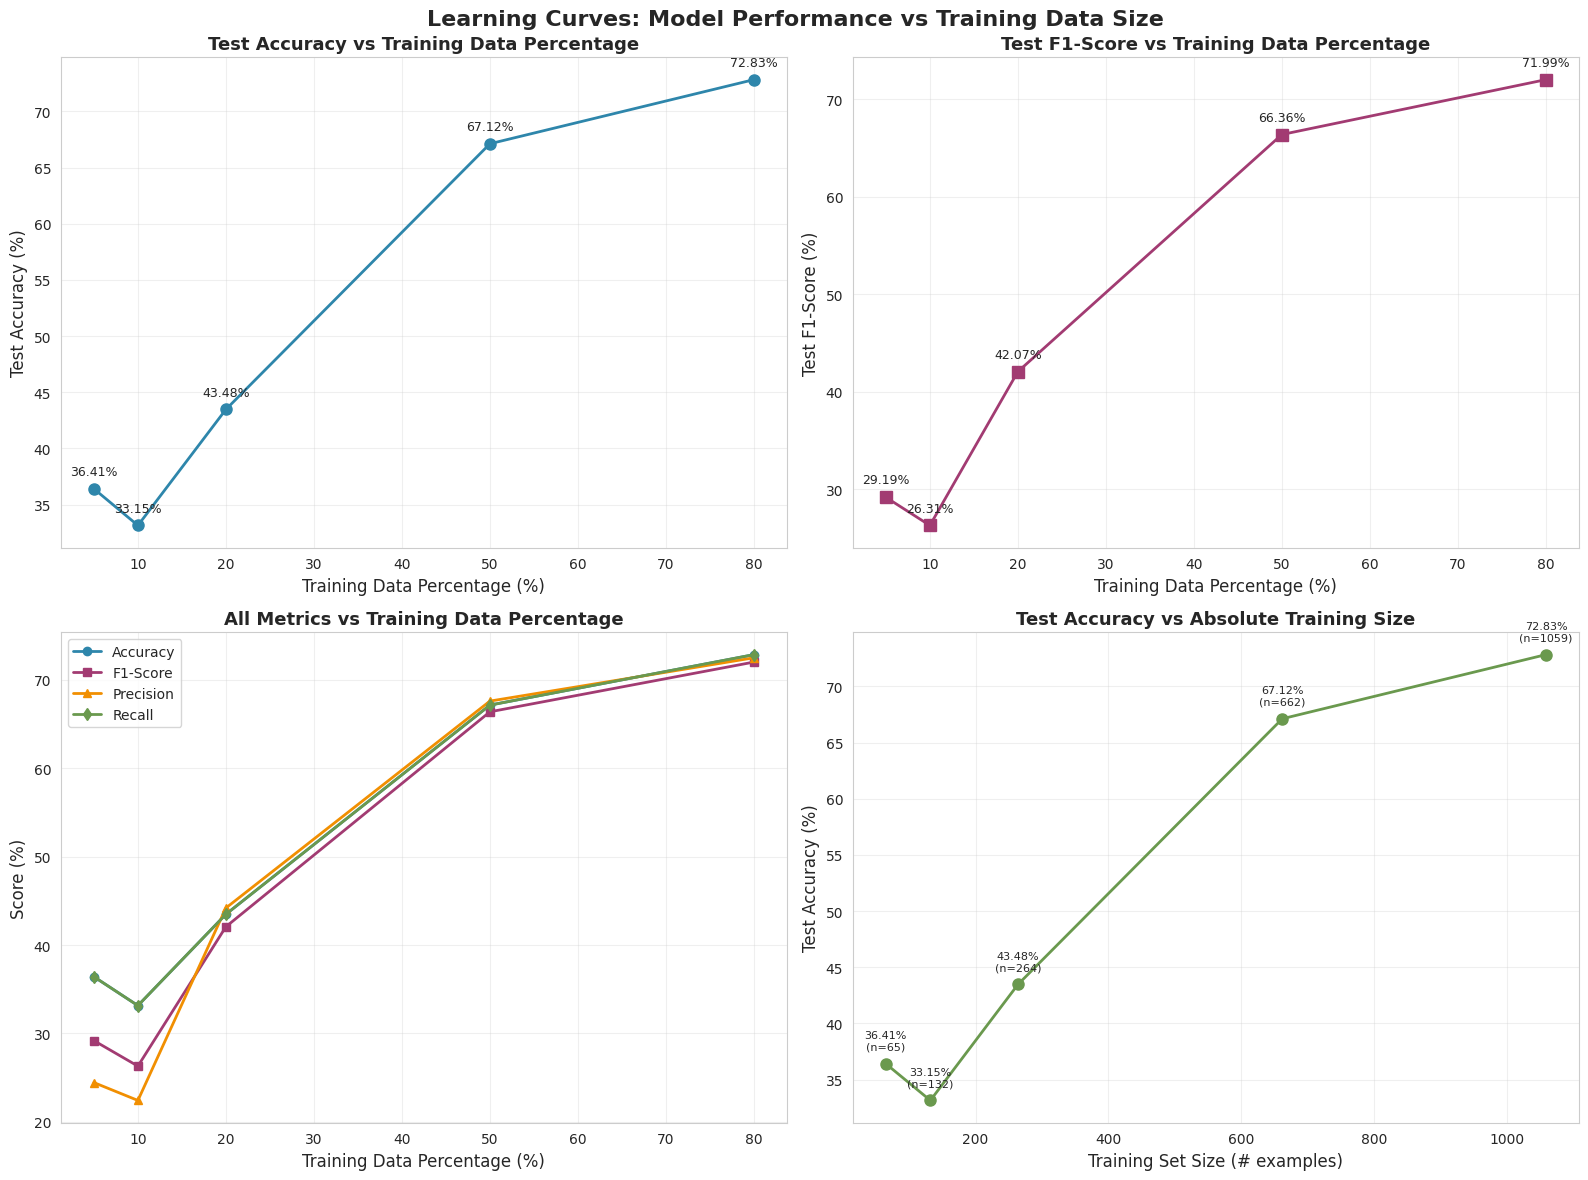

💾 SAVING RESULTS
✅ Results saved to 'learning_curve_results.csv'
✅ Test set saved to 'test_set.csv'
✅ Summary saved to 'learning_curve_summary.txt'

🎉 EXPERIMENT COMPLETE!

Generated files:
  - learning_curve.png: Visualization of results
  - learning_curve_results.csv: Detailed results table
  - learning_curve_summary.txt: Text summary
  - test_set.csv: Fixed test set used for all evaluations
  - Models saved in folders: ./afroxlmr_zulu_sentiment_5pct, ..., ./afroxlmr_zulu_sentiment_80pct



In [ ]:
"""
AfroXLMR Sentiment Analysis - TRAINING CODE WITH LEARNING CURVE
Fine-tune AfroXLMR on different percentages of Zulu sentiment data
"""

# ============================================================================
# Step 0: Install and Import Dependencies
# ============================================================================
print("="*80)
print("📦 INSTALLING DEPENDENCIES")
print("="*80)

!pip install -q transformers torch scikit-learn matplotlib seaborn pandas numpy datasets accelerate

import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
import json
import os
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully!")

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
print()

# ============================================================================
# Configuration
# ============================================================================
class Config:
    MODEL_NAME = "Davlan/afro-xlmr-base"
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EPOCHS = 5
    WARMUP_STEPS = 100
    WEIGHT_DECAY = 0.01
    SEED = 42
    SAVE_DIR = "./afroxlmr_zulu_sentiment"

    # Label mappings
    ID2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}
    LABEL2ID = {'negative': 0, 'neutral': 1, 'positive': 2}
    NUM_LABELS = 3

    # Training data percentages to test
    TRAIN_PERCENTAGES = [5, 10, 20, 50, 80]

# Set random seeds
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

print("="*80)
print("🎓 TRAINING AFROXLMR ON VARYING AMOUNTS OF ZULU DATA")
print("="*80)
print()

# ============================================================================
# Step 1: Load Dataset
# ============================================================================
print("="*80)
print("📂 LOADING ZULU DATASET")
print("="*80)

print("Please upload your Zulu sentiment dataset (.csv file):")
uploaded = files.upload()

zulu_filename = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {zulu_filename}")

# Load data
df = pd.read_csv(zulu_filename)
print(f"Loaded: {len(df)} examples")
print(f"Columns: {list(df.columns)}")

# Standardize columns
if 'Zulu' in df.columns:
    df = df.rename(columns={'Zulu': 'text'})
if 'new_sentiment' in df.columns:
    df = df.rename(columns={'new_sentiment': 'label'})

# Standardize labels
def standardize_label(label):
    label = str(label).strip().lower()
    if 'neg' in label:
        return 0
    elif 'neu' in label:
        return 1
    elif 'pos' in label:
        return 2
    else:
        return 1

df['label'] = df['label'].apply(standardize_label)

print("\nLabel distribution:")
for label_id in sorted(df['label'].unique()):
    count = (df['label'] == label_id).sum()
    pct = count / len(df) * 100
    print(f"  {Config.ID2LABEL[label_id].capitalize():8s}: {count:4d} ({pct:5.2f}%)")
print()

# ============================================================================
# Step 2: Split Dataset (Test set remains constant at 20%)
# ============================================================================
print("="*80)
print("✂️  SPLITTING DATASET")
print("="*80)

# First split: 80% for training variations, 20% for testing (fixed)
train_full_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=Config.SEED,
    stratify=df['label']
)

print(f"Available for training: {len(train_full_df)} examples (80% of total)")
print(f"Test set (fixed):       {len(test_df)} examples (20% of total)")
print()

# ============================================================================
# Helper Functions
# ============================================================================

def tokenize_function(examples, tokenizer):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=Config.MAX_LENGTH
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def prepare_datasets(train_df, val_df, test_df, tokenizer):
    """Convert dataframes to HuggingFace datasets and tokenize"""
    train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
    val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
    test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

    train_dataset = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    val_dataset = val_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    test_dataset = test_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    return train_dataset, val_dataset, test_dataset

# ============================================================================
# Step 3: Train on Different Data Percentages
# ============================================================================
print("="*80)
print("🚀 TRAINING ON MULTIPLE DATA PERCENTAGES")
print("="*80)
print()

# Load tokenizer once
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

# Store results
results = {
    'percentage': [],
    'train_size': [],
    'val_size': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_precision': [],
    'test_recall': []
}

for percentage in Config.TRAIN_PERCENTAGES:
    print("="*80)
    print(f"📊 TRAINING WITH {percentage}% OF AVAILABLE TRAINING DATA")
    print("="*80)
    print()

    # Calculate the size of this training subset
    # percentage is of the 80% training data, not total
    subset_size = int(len(train_full_df) * (percentage / 100))

    # Sample from the full training set with stratification
    if subset_size >= Config.NUM_LABELS * 2:  # Need at least 2 samples per class
        # Stratified sampling: sample proportionally from each class
        train_subset_df = train_full_df.groupby('label', group_keys=False).apply(
            lambda x: x.sample(frac=percentage/100, random_state=Config.SEED)
        ).reset_index(drop=True)
    else:
        # For very small samples, just random sample
        train_subset_df = train_full_df.sample(
            n=subset_size,
            random_state=Config.SEED
        ).reset_index(drop=True)

    # Split into train and validation (90/10 split of the subset)
    train_df, val_df = train_test_split(
        train_subset_df,
        test_size=0.1,
        random_state=Config.SEED,
        stratify=train_subset_df['label'] if len(train_subset_df) >= 20 else None
    )

    print(f"Training set:   {len(train_df)} examples ({percentage}% of available)")
    print(f"Validation set: {len(val_df)} examples")
    print(f"Test set:       {len(test_df)} examples (fixed)")
    print()

    # Prepare datasets
    train_dataset, val_dataset, test_dataset = prepare_datasets(
        train_df, val_df, test_df, tokenizer
    )

    # Load fresh model for each training run
    model = AutoModelForSequenceClassification.from_pretrained(
        Config.MODEL_NAME,
        num_labels=Config.NUM_LABELS,
        id2label=Config.ID2LABEL,
        label2id=Config.LABEL2ID
    )
    model.to(device)

    # Training arguments
    save_dir = f"{Config.SAVE_DIR}_{percentage}pct"
    training_args = TrainingArguments(
        output_dir=save_dir,
        num_train_epochs=Config.EPOCHS,
        per_device_train_batch_size=Config.BATCH_SIZE,
        per_device_eval_batch_size=Config.BATCH_SIZE,
        warmup_steps=Config.WARMUP_STEPS,
        weight_decay=Config.WEIGHT_DECAY,
        learning_rate=Config.LEARNING_RATE,
        logging_dir=f'{save_dir}/logs',
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=2,
        report_to="none"
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train
    print(f"🏋️  Training with {percentage}% of data...")
    trainer.train()
    print(f"✅ Training completed for {percentage}%\n")

    # Evaluate on test set
    print(f"📊 Evaluating on test set...")
    test_results = trainer.evaluate(test_dataset)

    print(f"\nTest Results for {percentage}% training data:")
    print(f"  Accuracy:  {test_results['eval_accuracy']:.4f} ({test_results['eval_accuracy']*100:.2f}%)")
    print(f"  F1-Score:  {test_results['eval_f1']:.4f} ({test_results['eval_f1']*100:.2f}%)")
    print(f"  Precision: {test_results['eval_precision']:.4f} ({test_results['eval_precision']*100:.2f}%)")
    print(f"  Recall:    {test_results['eval_recall']:.4f} ({test_results['eval_recall']*100:.2f}%)")
    print()

    # Store results
    results['percentage'].append(percentage)
    results['train_size'].append(len(train_df))
    results['val_size'].append(len(val_df))
    results['test_accuracy'].append(test_results['eval_accuracy'])
    results['test_f1'].append(test_results['eval_f1'])
    results['test_precision'].append(test_results['eval_precision'])
    results['test_recall'].append(test_results['eval_recall'])

    # Save this model
    trainer.save_model(save_dir)
    tokenizer.save_pretrained(save_dir)

    # Save configuration for this run
    config_dict = {
        'model_name': Config.MODEL_NAME,
        'max_length': Config.MAX_LENGTH,
        'num_labels': Config.NUM_LABELS,
        'id2label': Config.ID2LABEL,
        'label2id': Config.LABEL2ID,
        'train_percentage': percentage,
        'train_size': len(train_df),
        'val_size': len(val_df),
        'test_size': len(test_df),
        'test_accuracy': test_results['eval_accuracy'],
        'test_f1': test_results['eval_f1'],
        'test_precision': test_results['eval_precision'],
        'test_recall': test_results['eval_recall']
    }

    with open(f"{save_dir}/config.json", 'w') as f:
        json.dump(config_dict, f, indent=2)

    print(f"💾 Model saved to: {save_dir}\n")

    # Clean up to free memory
    del model
    del trainer
    torch.cuda.empty_cache()

# ============================================================================
# Step 4: Create Learning Curve Visualization
# ============================================================================
print("="*80)
print("📈 CREATING LEARNING CURVE VISUALIZATION")
print("="*80)
print()

# Create results dataframe
results_df = pd.DataFrame(results)
print("Summary of Results:")
print(results_df.to_string(index=False))
print()

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Learning Curves: Model Performance vs Training Data Size',
             fontsize=16, fontweight='bold')

# Plot 1: Accuracy vs Training Data Percentage
ax1 = axes[0, 0]
ax1.plot(results_df['percentage'], results_df['test_accuracy'] * 100,
         marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax1.set_xlabel('Training Data Percentage (%)', fontsize=12)
ax1.set_ylabel('Test Accuracy (%)', fontsize=12)
ax1.set_title('Test Accuracy vs Training Data Percentage', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
for i, (x, y) in enumerate(zip(results_df['percentage'], results_df['test_accuracy'] * 100)):
    ax1.annotate(f'{y:.2f}%', (x, y), textcoords="offset points",
                xytext=(0,10), ha='center', fontsize=9)

# Plot 2: F1-Score vs Training Data Percentage
ax2 = axes[0, 1]
ax2.plot(results_df['percentage'], results_df['test_f1'] * 100,
         marker='s', linewidth=2, markersize=8, color='#A23B72')
ax2.set_xlabel('Training Data Percentage (%)', fontsize=12)
ax2.set_ylabel('Test F1-Score (%)', fontsize=12)
ax2.set_title('Test F1-Score vs Training Data Percentage', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
for i, (x, y) in enumerate(zip(results_df['percentage'], results_df['test_f1'] * 100)):
    ax2.annotate(f'{y:.2f}%', (x, y), textcoords="offset points",
                xytext=(0,10), ha='center', fontsize=9)

# Plot 3: All Metrics Together
ax3 = axes[1, 0]
ax3.plot(results_df['percentage'], results_df['test_accuracy'] * 100,
         marker='o', linewidth=2, markersize=6, label='Accuracy', color='#2E86AB')
ax3.plot(results_df['percentage'], results_df['test_f1'] * 100,
         marker='s', linewidth=2, markersize=6, label='F1-Score', color='#A23B72')
ax3.plot(results_df['percentage'], results_df['test_precision'] * 100,
         marker='^', linewidth=2, markersize=6, label='Precision', color='#F18F01')
ax3.plot(results_df['percentage'], results_df['test_recall'] * 100,
         marker='d', linewidth=2, markersize=6, label='Recall', color='#6A994E')
ax3.set_xlabel('Training Data Percentage (%)', fontsize=12)
ax3.set_ylabel('Score (%)', fontsize=12)
ax3.set_title('All Metrics vs Training Data Percentage', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Accuracy vs Absolute Training Size
ax4 = axes[1, 1]
ax4.plot(results_df['train_size'], results_df['test_accuracy'] * 100,
         marker='o', linewidth=2, markersize=8, color='#6A994E')
ax4.set_xlabel('Training Set Size (# examples)', fontsize=12)
ax4.set_ylabel('Test Accuracy (%)', fontsize=12)
ax4.set_title('Test Accuracy vs Absolute Training Size', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
for i, (x, y) in enumerate(zip(results_df['train_size'], results_df['test_accuracy'] * 100)):
    ax4.annotate(f'{y:.2f}%\n(n={x})', (x, y), textcoords="offset points",
                xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
print("✅ Learning curve saved as 'learning_curve.png'")
plt.show()

# ============================================================================
# Step 5: Save Results
# ============================================================================
print("="*80)
print("💾 SAVING RESULTS")
print("="*80)

# Save results to CSV
results_df.to_csv('learning_curve_results.csv', index=False)
print("✅ Results saved to 'learning_curve_results.csv'")

# Save test set (same for all models)
test_df.to_csv('test_set.csv', index=False)
print("✅ Test set saved to 'test_set.csv'")

# Save detailed summary
with open('learning_curve_summary.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("LEARNING CURVE EXPERIMENT SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"Model: {Config.MODEL_NAME}\n")
    f.write(f"Test set size: {len(test_df)} examples (fixed across all runs)\n")
    f.write(f"Training percentages tested: {Config.TRAIN_PERCENTAGES}\n\n")
    f.write("Results by training data percentage:\n\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\n")
    f.write("Key Findings:\n")
    f.write(f"- Best accuracy: {results_df['test_accuracy'].max()*100:.2f}% ")
    f.write(f"(at {results_df.loc[results_df['test_accuracy'].idxmax(), 'percentage']}% training data)\n")
    f.write(f"- Worst accuracy: {results_df['test_accuracy'].min()*100:.2f}% ")
    f.write(f"(at {results_df.loc[results_df['test_accuracy'].idxmin(), 'percentage']}% training data)\n")
    f.write(f"- Improvement from 5% to 80%: {(results_df['test_accuracy'].iloc[-1] - results_df['test_accuracy'].iloc[0])*100:.2f} percentage points\n")

print("✅ Summary saved to 'learning_curve_summary.txt'")
print()

print("="*80)
print("🎉 EXPERIMENT COMPLETE!")
print("="*80)
print()
print("Generated files:")
print("  - learning_curve.png: Visualization of results")
print("  - learning_curve_results.csv: Detailed results table")
print("  - learning_curve_summary.txt: Text summary")
print("  - test_set.csv: Fixed test set used for all evaluations")
print(f"  - Models saved in folders: {Config.SAVE_DIR}_5pct, ..., {Config.SAVE_DIR}_80pct")
print()

This trains on Zulu and Swah and does zero shot prompting on both

📦 INSTALLING DEPENDENCIES
✅ All packages imported successfully!

🖥️  Device: cuda
   GPU: NVIDIA A100-SXM4-40GB

🎓 BINARY SENTIMENT CLASSIFICATION: SWAHILI vs ZULU

📤 STEP 1: Upload SWAHILI training data
Expected: CSV/Excel with 'text' and 'label' columns
Labels should be negative/positive (neutral will be removed)


Saving swahili.csv to swahili (4).csv

📂 Loading Swahili data from: swahili (4).csv
✅ Loaded: 3925 rows
Columns: ['text', 'labels']
✅ Renamed 'labels' to 'label'
✅ After cleaning: 3925 samples (removed 0 neutral/invalid)

Label distribution:
  0 (negative): 1923 (49.0%)
  1 (positive): 2002 (51.0%)

✂️  Swahili split:
  Training:   2747 samples
  Validation: 393 samples
  Test:       785 samples

📤 STEP 2: Upload ZULU training data (different from test)
Expected: CSV/Excel with 'text'/'Zulu' and 'label'/'sentiment' columns
Labels should be negative/positive (neutral will be removed)


Saving zulu_sentiment_balanced_for_suh.csv to zulu_sentiment_balanced_for_suh (2).csv

📂 Loading Zulu training data from: zulu_sentiment_balanced_for_suh (2).csv
✅ Loaded: 1839 rows
Columns: ['Zulu', 'new_sentiment']
✅ Renamed 'Zulu' to 'text'
✅ Renamed 'new_sentiment' to 'label'
✅ After cleaning: 1226 samples (removed 613 neutral/invalid)

Label distribution:
  0 (negative): 613 (50.0%)
  1 (positive): 613 (50.0%)

✂️  Zulu split:
  Training:   857 samples
  Validation: 123 samples
  Test:       246 samples

📤 STEP 3: Upload ZULU test data (for zero-shot evaluation)
This should be a SEPARATE Zulu dataset not used in training


Saving testing_sw.xlsx to testing_sw (1).xlsx

📂 Loading Zulu holdout data from: testing_sw (1).xlsx
✅ Loaded: 250 rows
Columns: ['Zulu', 'new_sentiment']
✅ Renamed 'Zulu' to 'text'
✅ Renamed 'new_sentiment' to 'label'
✅ After cleaning: 158 samples (removed 92 neutral/invalid)

Label distribution:
  0 (negative): 87 (55.1%)
  1 (positive): 71 (44.9%)

✅ Zulu holdout: 158 samples (completely unseen)

🔤 TOKENIZING DATASETS


Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

Map:   0%|          | 0/393 [00:00<?, ? examples/s]

Map:   0%|          | 0/785 [00:00<?, ? examples/s]

Map:   0%|          | 0/857 [00:00<?, ? examples/s]

Map:   0%|          | 0/123 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ All datasets tokenized

🌍 TRAINING MODEL #1: SWAHILI

🤖 Loading model for Swahili Model...
🚀 Training Swahili Model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.554500,0.481961,0.788804,0.773842,0.855422,0.706468
2,0.396400,0.435740,0.824427,0.817942,0.870787,0.771144
3,0.272500,0.469942,0.829517,0.826873,0.860215,0.796020
4,0.223100,0.464111,0.842239,0.846535,0.842365,0.850746
5,0.165500,0.517329,0.847328,0.846939,0.869110,0.825871


✅ Training complete for Swahili Model!



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


💾 Swahili model saved

🌍 TRAINING MODEL #2: ZULU

🤖 Loading model for Zulu Model...
🚀 Training Zulu Model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.692000,0.683570,0.585366,0.548673,0.596154,0.508197
2,0.651000,0.425722,0.813008,0.792793,0.880000,0.721311
3,0.337400,0.321316,0.861789,0.859504,0.866667,0.852459
4,0.204100,0.394602,0.878049,0.883721,0.838235,0.934426
5,0.133300,0.429218,0.886179,0.890625,0.850746,0.934426


✅ Training complete for Zulu Model!

💾 Zulu model saved

📊 COMPREHENSIVE EVALUATION

📈 SWAHILI MODEL EVALUATION

1️⃣  Swahili Model on Swahili Test (In-Language)
📊 Evaluating on Swahili Model → Swahili Test...



Swahili Model → Swahili Test Results:
  Accuracy:  0.8662 (86.62%)
  F1-Score:  0.8679
  Precision: 0.8734
  Recall:    0.8625

Per-class accuracy:
  negative: 0.8701 (385 samples)
  positive: 0.8625 (400 samples)

Swahili Model → Swahili Test Classification Report:
              precision    recall  f1-score   support

    negative     0.8590    0.8701    0.8645       385
    positive     0.8734    0.8625    0.8679       400

    accuracy                         0.8662       785
   macro avg     0.8662    0.8663    0.8662       785
weighted avg     0.8663    0.8662    0.8663       785


2️⃣  Swahili Model on Zulu Holdout (Zero-Shot Cross-Lingual)
📊 Evaluating on Swahili Model → Zulu Holdout...



Swahili Model → Zulu Holdout Results:
  Accuracy:  0.6329 (63.29%)
  F1-Score:  0.6420
  Precision: 0.5714
  Recall:    0.7324

Per-class accuracy:
  negative: 0.5517 (87 samples)
  positive: 0.7324 (71 samples)

Swahili Model → Zulu Holdout Classification Report:
              precision    recall  f1-score   support

    negative     0.7164    0.5517    0.6234        87
    positive     0.5714    0.7324    0.6420        71

    accuracy                         0.6329       158
   macro avg     0.6439    0.6421    0.6327       158
weighted avg     0.6513    0.6329    0.6317       158


📈 ZULU MODEL EVALUATION

3️⃣  Zulu Model on Zulu Test (In-Language)
📊 Evaluating on Zulu Model → Zulu Test...



Zulu Model → Zulu Test Results:
  Accuracy:  0.8821 (88.21%)
  F1-Score:  0.8835
  Precision: 0.8730
  Recall:    0.8943

Per-class accuracy:
  negative: 0.8699 (123 samples)
  positive: 0.8943 (123 samples)

Zulu Model → Zulu Test Classification Report:
              precision    recall  f1-score   support

    negative     0.8917    0.8699    0.8807       123
    positive     0.8730    0.8943    0.8835       123

    accuracy                         0.8821       246
   macro avg     0.8823    0.8821    0.8821       246
weighted avg     0.8823    0.8821    0.8821       246


4️⃣  Zulu Model on Zulu Holdout (In-Language)
📊 Evaluating on Zulu Model → Zulu Holdout...



Zulu Model → Zulu Holdout Results:
  Accuracy:  0.9620 (96.20%)
  F1-Score:  0.9577
  Precision: 0.9577
  Recall:    0.9577

Per-class accuracy:
  negative: 0.9655 (87 samples)
  positive: 0.9577 (71 samples)

Zulu Model → Zulu Holdout Classification Report:
              precision    recall  f1-score   support

    negative     0.9655    0.9655    0.9655        87
    positive     0.9577    0.9577    0.9577        71

    accuracy                         0.9620       158
   macro avg     0.9616    0.9616    0.9616       158
weighted avg     0.9620    0.9620    0.9620       158


5️⃣  Zulu Model on Swahili Test (Reverse Cross-Lingual)
📊 Evaluating on Zulu Model → Swahili Test...



Zulu Model → Swahili Test Results:
  Accuracy:  0.7363 (73.63%)
  F1-Score:  0.7429
  Precision: 0.7383
  Recall:    0.7475

Per-class accuracy:
  negative: 0.7247 (385 samples)
  positive: 0.7475 (400 samples)

Zulu Model → Swahili Test Classification Report:
              precision    recall  f1-score   support

    negative     0.7342    0.7247    0.7294       385
    positive     0.7383    0.7475    0.7429       400

    accuracy                         0.7363       785
   macro avg     0.7362    0.7361    0.7361       785
weighted avg     0.7363    0.7363    0.7363       785


📊 CREATING VISUALIZATIONS
✅ Main comparison graph saved: 'swahili_vs_zulu_comparison.png'
✅ Transfer gap analysis saved: 'transfer_gap_analysis.png'


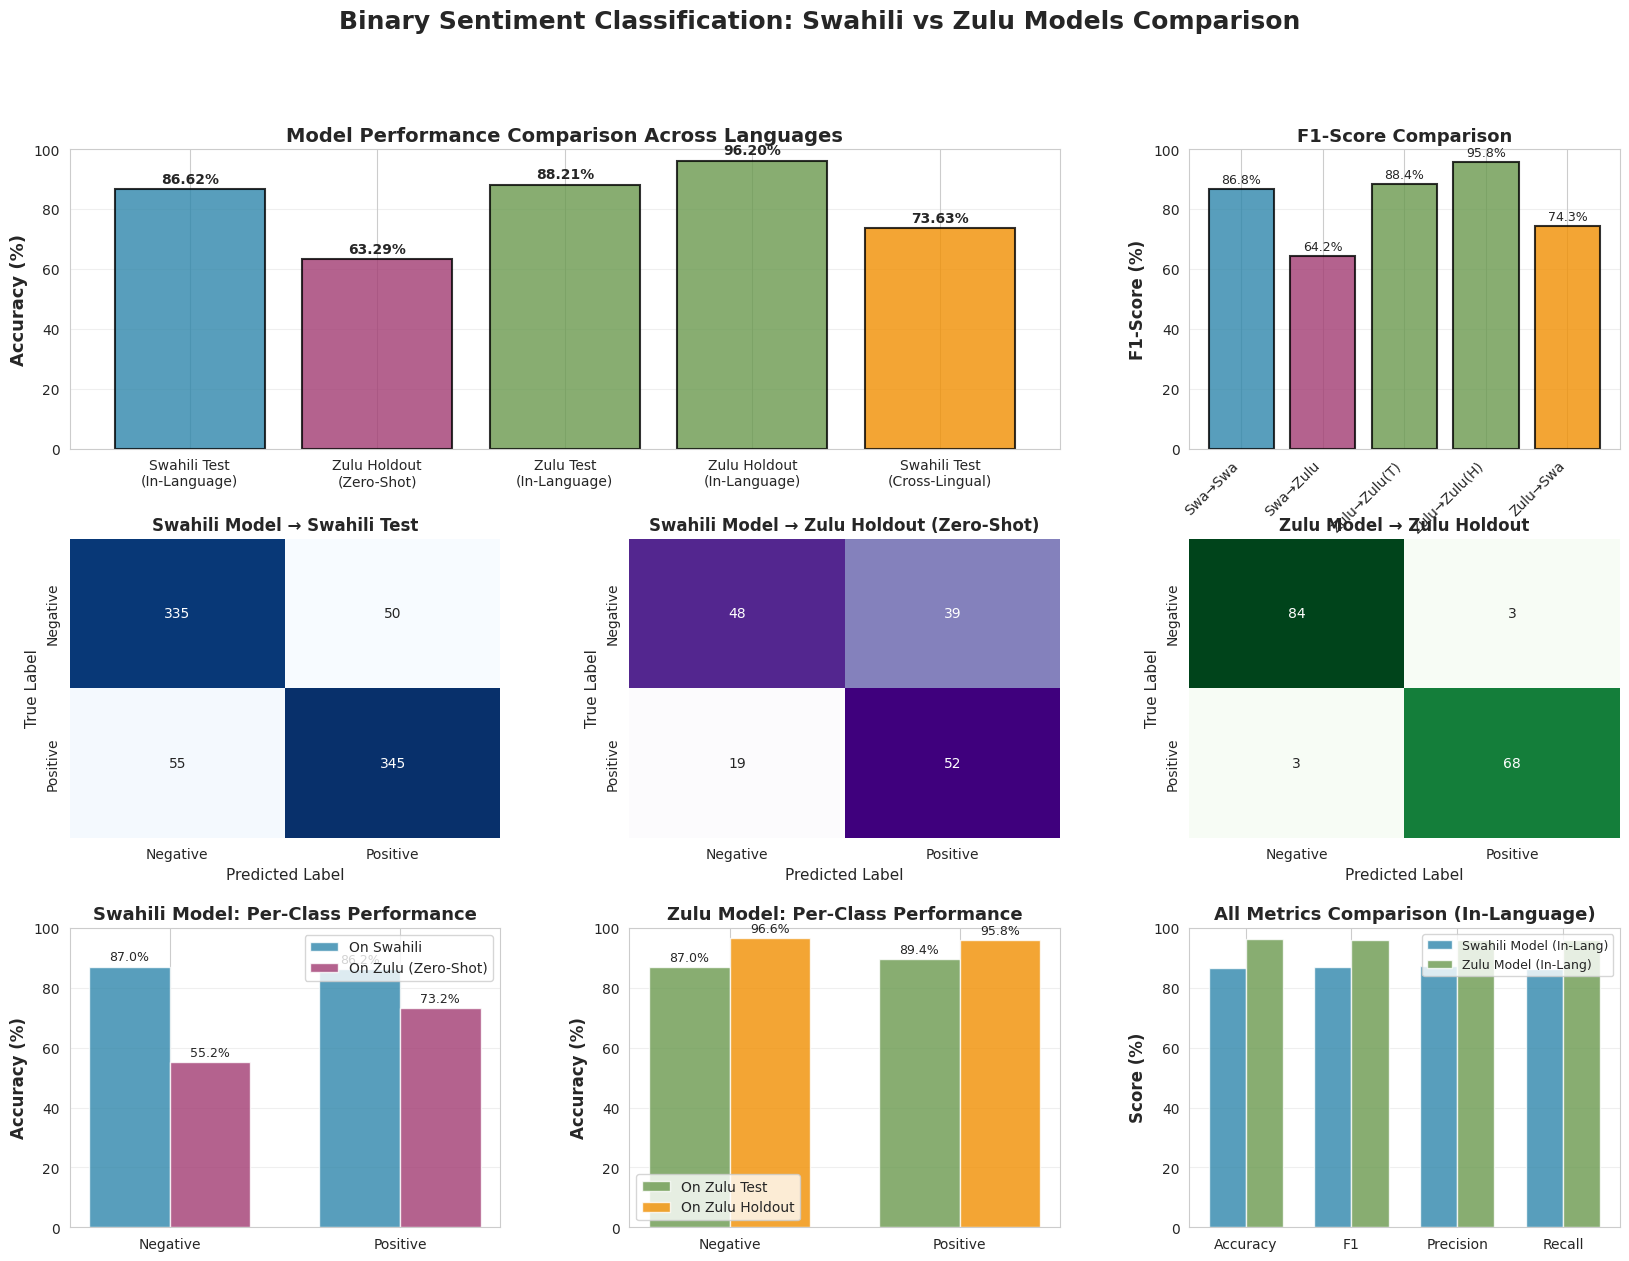

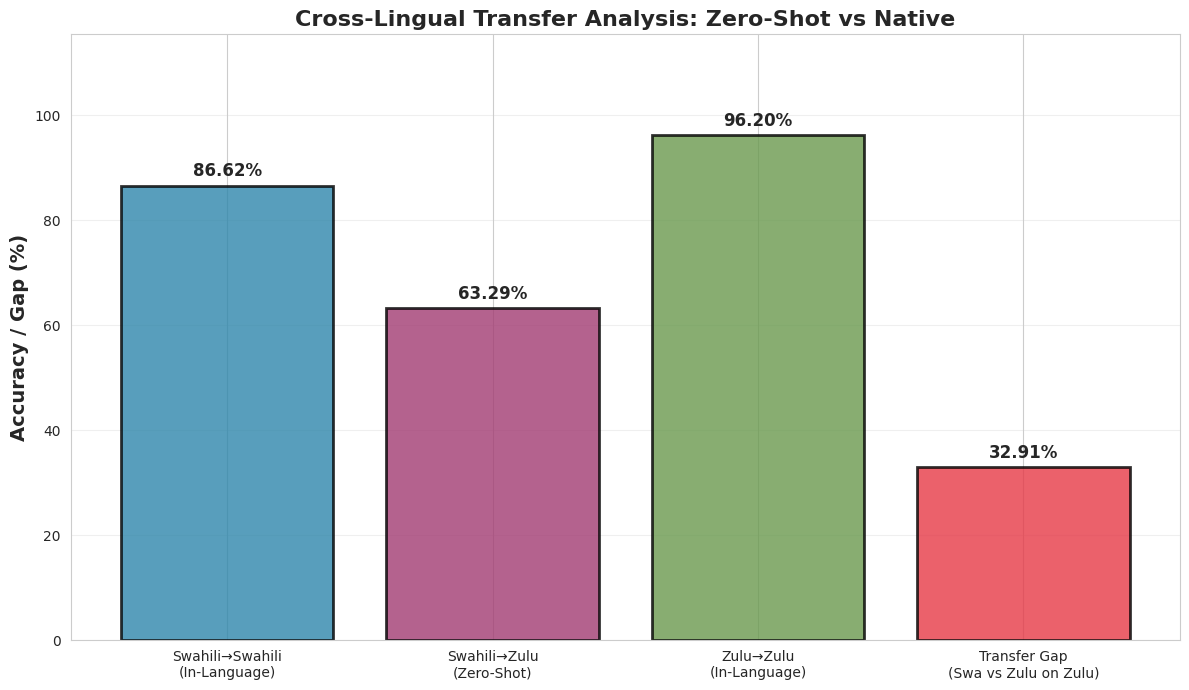


💾 SAVING RESULTS
✅ Results saved to: 'model_comparison_results.csv'
✅ Summary saved to: 'experiment_summary.txt'

🎉 EXPERIMENT COMPLETE!

📊 QUICK SUMMARY:

🌍 Swahili Model Performance:
  • On Swahili (in-language): 86.62%
  • On Zulu (zero-shot): 63.29%

🌍 Zulu Model Performance:
  • On Zulu test (in-language): 88.21%
  • On Zulu holdout (in-language): 96.20%
  • On Swahili (cross-lingual): 73.63%

📉 Zero-Shot Transfer Gap: 32.91 percentage points
⚠️  Significant performance gap - native model performs much better

📁 Generated Files:
  • swahili_vs_zulu_comparison.png (main comparison graphs)
  • transfer_gap_analysis.png (transfer analysis)
  • model_comparison_results.csv (detailed metrics)
  • experiment_summary.txt (text summary)
  • ./model_swahili_binary/ (trained Swahili model)
  • ./model_zulu_binary/ (trained Zulu model)

Done! 🎉


In [ ]:
"""
Binary Sentiment Classification: Swahili vs Zulu Training
Train separate models on Swahili and Zulu, compare performance with graphs
"""

# ============================================================================
# Step 0: Install & Import Dependencies
# ============================================================================
print("="*80)
print("📦 INSTALLING DEPENDENCIES")
print("="*80)

!pip install -q transformers torch scikit-learn pandas datasets accelerate openpyxl matplotlib seaborn

import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
import json
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
print()

# ============================================================================
# Configuration
# ============================================================================
class Config:
    MODEL_NAME = "Davlan/afro-xlmr-base"
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    EPOCHS = 5
    WARMUP_STEPS = 100
    WEIGHT_DECAY = 0.01
    SEED = 42

    # Binary Label mappings
    ID2LABEL = {0: 'negative', 1: 'positive'}
    LABEL2ID = {'negative': 0, 'positive': 1}
    NUM_LABELS = 2

torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

print("="*80)
print("🎓 BINARY SENTIMENT CLASSIFICATION: SWAHILI vs ZULU")
print("="*80)
print()

# ============================================================================
# Helper Functions
# ============================================================================

def standardize_binary_label(label):
    """Convert various label formats to binary 0/1"""
    label = str(label).strip().lower()
    if 'neg' in label or label == '0':
        return 0
    elif 'pos' in label or label == '1' or label == '2':
        return 1
    else:
        return None  # Neutral or unknown

def load_and_prepare_data(file_path, text_col_names=['text', 'Zulu'],
                          label_col_names=['label', 'new_sentiment', 'sentiment']):
    """Load data from CSV/Excel and standardize format"""
    # Load file
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        df = pd.read_excel(file_path)

    print(f"✅ Loaded: {len(df)} rows")
    print(f"Columns: {list(df.columns)}")

    # Find text column
    text_col = None
    for col in text_col_names:
        if col in df.columns:
            text_col = col
            break
    if text_col is None:
        text_col = [col for col in df.columns if 'text' in col.lower() or 'tweet' in col.lower()][0]

    if text_col != 'text':
        df = df.rename(columns={text_col: 'text'})
        print(f"✅ Renamed '{text_col}' to 'text'")

    # Find label column
    label_col = None
    for col in label_col_names:
        if col in df.columns:
            label_col = col
            break
    if label_col is None:
        label_col = [col for col in df.columns if 'label' in col.lower() or 'sentiment' in col.lower()][0]

    if label_col != 'label':
        df = df.rename(columns={label_col: 'label'})
        print(f"✅ Renamed '{label_col}' to 'label'")

    # Standardize labels
    df['label'] = df['label'].apply(standardize_binary_label)

    # Remove neutral/invalid
    neutral_count = df['label'].isna().sum()
    df = df[['text', 'label']].dropna()
    df = df[df['label'].isin([0, 1])]
    df['label'] = df['label'].astype(int)

    print(f"✅ After cleaning: {len(df)} samples (removed {neutral_count} neutral/invalid)")
    print(f"\nLabel distribution:")
    for i, label_name in enumerate(['negative', 'positive']):
        count = (df['label'] == i).sum()
        pct = count / len(df) * 100
        print(f"  {i} ({label_name}): {count} ({pct:.1f}%)")

    return df

def tokenize_function(examples, tokenizer):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=Config.MAX_LENGTH
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def train_model(train_dataset, val_dataset, model_name, save_dir):
    """Train a model and return the trainer"""
    print(f"\n🤖 Loading model for {model_name}...")

    model = AutoModelForSequenceClassification.from_pretrained(
        Config.MODEL_NAME,
        num_labels=Config.NUM_LABELS,
        id2label=Config.ID2LABEL,
        label2id=Config.LABEL2ID
    )
    model.to(device)

    training_args = TrainingArguments(
        output_dir=save_dir,
        num_train_epochs=Config.EPOCHS,
        per_device_train_batch_size=Config.BATCH_SIZE,
        per_device_eval_batch_size=Config.BATCH_SIZE,
        warmup_steps=Config.WARMUP_STEPS,
        weight_decay=Config.WEIGHT_DECAY,
        learning_rate=Config.LEARNING_RATE,
        logging_dir=f'{save_dir}/logs',
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=2,
        report_to="none",
        seed=Config.SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    print(f"🚀 Training {model_name}...")
    trainer.train()
    print(f"✅ Training complete for {model_name}!\n")

    return trainer

def evaluate_and_save(trainer, dataset, dataset_name, save_prefix):
    """Evaluate model and return detailed results"""
    print(f"📊 Evaluating on {dataset_name}...")

    results = trainer.evaluate(dataset)
    predictions = trainer.predict(dataset)
    pred_labels = predictions.predictions.argmax(-1)
    true_labels = predictions.label_ids

    # Get probabilities
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Per-class metrics
    class_metrics = {}
    for i, label_name in enumerate(['negative', 'positive']):
        mask = true_labels == i
        if mask.sum() > 0:
            class_acc = (pred_labels[mask] == true_labels[mask]).sum() / mask.sum()
            class_metrics[label_name] = {
                'accuracy': class_acc,
                'count': mask.sum()
            }

    print(f"\n{dataset_name} Results:")
    print(f"  Accuracy:  {results['eval_accuracy']:.4f} ({results['eval_accuracy']*100:.2f}%)")
    print(f"  F1-Score:  {results['eval_f1']:.4f}")
    print(f"  Precision: {results['eval_precision']:.4f}")
    print(f"  Recall:    {results['eval_recall']:.4f}")

    print(f"\nPer-class accuracy:")
    for label_name, metrics in class_metrics.items():
        print(f"  {label_name}: {metrics['accuracy']:.4f} ({metrics['count']} samples)")

    print(f"\n{dataset_name} Classification Report:")
    print(classification_report(true_labels, pred_labels,
                               target_names=['negative', 'positive'], digits=4))

    return {
        'results': results,
        'predictions': pred_labels,
        'true_labels': true_labels,
        'probabilities': probs,
        'confusion_matrix': cm,
        'class_metrics': class_metrics
    }

# ============================================================================
# Step 1: Load Swahili Dataset
# ============================================================================
print("="*80)
print("📤 STEP 1: Upload SWAHILI training data")
print("="*80)
print("Expected: CSV/Excel with 'text' and 'label' columns")
print("Labels should be negative/positive (neutral will be removed)")
print("="*80)

uploaded_swahili = files.upload()
swahili_file = list(uploaded_swahili.keys())[0]

print(f"\n📂 Loading Swahili data from: {swahili_file}")
swahili_df = load_and_prepare_data(swahili_file)

# Split Swahili: 70% train, 10% val, 20% test
swahili_train_val, swahili_test = train_test_split(
    swahili_df, test_size=0.2, random_state=Config.SEED, stratify=swahili_df['label']
)
swahili_train, swahili_val = train_test_split(
    swahili_train_val, test_size=0.125, random_state=Config.SEED,
    stratify=swahili_train_val['label']
)

print(f"\n✂️  Swahili split:")
print(f"  Training:   {len(swahili_train)} samples")
print(f"  Validation: {len(swahili_val)} samples")
print(f"  Test:       {len(swahili_test)} samples")

# ============================================================================
# Step 2: Load Zulu Training Dataset
# ============================================================================
print("\n" + "="*80)
print("📤 STEP 2: Upload ZULU training data (different from test)")
print("="*80)
print("Expected: CSV/Excel with 'text'/'Zulu' and 'label'/'sentiment' columns")
print("Labels should be negative/positive (neutral will be removed)")
print("="*80)

uploaded_zulu_train = files.upload()
zulu_train_file = list(uploaded_zulu_train.keys())[0]

print(f"\n📂 Loading Zulu training data from: {zulu_train_file}")
zulu_train_df = load_and_prepare_data(zulu_train_file)

# Split Zulu: 70% train, 10% val, 20% test
zulu_train_val, zulu_test = train_test_split(
    zulu_train_df, test_size=0.2, random_state=Config.SEED, stratify=zulu_train_df['label']
)
zulu_train, zulu_val = train_test_split(
    zulu_train_val, test_size=0.125, random_state=Config.SEED,
    stratify=zulu_train_val['label']
)

print(f"\n✂️  Zulu split:")
print(f"  Training:   {len(zulu_train)} samples")
print(f"  Validation: {len(zulu_val)} samples")
print(f"  Test:       {len(zulu_test)} samples")

# ============================================================================
# Step 3: Load Zulu Test Dataset (for zero-shot comparison)
# ============================================================================
print("\n" + "="*80)
print("📤 STEP 3: Upload ZULU test data (for zero-shot evaluation)")
print("="*80)
print("This should be a SEPARATE Zulu dataset not used in training")
print("="*80)

uploaded_zulu_holdout = files.upload()
zulu_holdout_file = list(uploaded_zulu_holdout.keys())[0]

print(f"\n📂 Loading Zulu holdout data from: {zulu_holdout_file}")
zulu_holdout_df = load_and_prepare_data(zulu_holdout_file)

print(f"\n✅ Zulu holdout: {len(zulu_holdout_df)} samples (completely unseen)")

# ============================================================================
# Step 4: Tokenize All Datasets
# ============================================================================
print("\n" + "="*80)
print("🔤 TOKENIZING DATASETS")
print("="*80)

tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

# Swahili datasets
swahili_train_dataset = Dataset.from_pandas(swahili_train).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)
swahili_val_dataset = Dataset.from_pandas(swahili_val).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)
swahili_test_dataset = Dataset.from_pandas(swahili_test).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)

# Zulu training datasets
zulu_train_dataset = Dataset.from_pandas(zulu_train).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)
zulu_val_dataset = Dataset.from_pandas(zulu_val).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)
zulu_test_dataset = Dataset.from_pandas(zulu_test).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)

# Zulu holdout dataset
zulu_holdout_dataset = Dataset.from_pandas(zulu_holdout_df).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)

print("✅ All datasets tokenized")

# ============================================================================
# Step 5: Train Model on Swahili
# ============================================================================
print("\n" + "="*80)
print("🌍 TRAINING MODEL #1: SWAHILI")
print("="*80)

swahili_trainer = train_model(
    swahili_train_dataset,
    swahili_val_dataset,
    "Swahili Model",
    "./model_swahili_binary"
)

# Save Swahili model
swahili_trainer.save_model("./model_swahili_binary")
tokenizer.save_pretrained("./model_swahili_binary")
print("💾 Swahili model saved")

# ============================================================================
# Step 6: Train Model on Zulu
# ============================================================================
print("\n" + "="*80)
print("🌍 TRAINING MODEL #2: ZULU")
print("="*80)

zulu_trainer = train_model(
    zulu_train_dataset,
    zulu_val_dataset,
    "Zulu Model",
    "./model_zulu_binary"
)

# Save Zulu model
zulu_trainer.save_model("./model_zulu_binary")
tokenizer.save_pretrained("./model_zulu_binary")
print("💾 Zulu model saved")

# ============================================================================
# Step 7: Evaluate Both Models
# ============================================================================
print("\n" + "="*80)
print("📊 COMPREHENSIVE EVALUATION")
print("="*80)

results_summary = {
    'swahili_model': {},
    'zulu_model': {}
}

# Evaluate Swahili model
print("\n" + "="*80)
print("📈 SWAHILI MODEL EVALUATION")
print("="*80)

print("\n1️⃣  Swahili Model on Swahili Test (In-Language)")
swahili_on_swahili = evaluate_and_save(
    swahili_trainer, swahili_test_dataset,
    "Swahili Model → Swahili Test", "swahili_swahili"
)
results_summary['swahili_model']['on_swahili'] = swahili_on_swahili

print("\n2️⃣  Swahili Model on Zulu Holdout (Zero-Shot Cross-Lingual)")
swahili_on_zulu = evaluate_and_save(
    swahili_trainer, zulu_holdout_dataset,
    "Swahili Model → Zulu Holdout", "swahili_zulu"
)
results_summary['swahili_model']['on_zulu'] = swahili_on_zulu

# Evaluate Zulu model
print("\n" + "="*80)
print("📈 ZULU MODEL EVALUATION")
print("="*80)

print("\n3️⃣  Zulu Model on Zulu Test (In-Language)")
zulu_on_zulu_test = evaluate_and_save(
    zulu_trainer, zulu_test_dataset,
    "Zulu Model → Zulu Test", "zulu_zulu_test"
)
results_summary['zulu_model']['on_zulu_test'] = zulu_on_zulu_test

print("\n4️⃣  Zulu Model on Zulu Holdout (In-Language)")
zulu_on_zulu_holdout = evaluate_and_save(
    zulu_trainer, zulu_holdout_dataset,
    "Zulu Model → Zulu Holdout", "zulu_zulu_holdout"
)
results_summary['zulu_model']['on_zulu_holdout'] = zulu_on_zulu_holdout

print("\n5️⃣  Zulu Model on Swahili Test (Reverse Cross-Lingual)")
zulu_on_swahili = evaluate_and_save(
    zulu_trainer, swahili_test_dataset,
    "Zulu Model → Swahili Test", "zulu_swahili"
)
results_summary['zulu_model']['on_swahili'] = zulu_on_swahili

# ============================================================================
# Step 8: Create Comprehensive Visualizations
# ============================================================================
print("\n" + "="*80)
print("📊 CREATING VISUALIZATIONS")
print("="*80)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 12)

# Create figure with subplots
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Binary Sentiment Classification: Swahili vs Zulu Models Comparison',
             fontsize=18, fontweight='bold', y=0.98)

# ============================================================================
# Plot 1: Accuracy Comparison Bar Chart
# ============================================================================
ax1 = fig.add_subplot(gs[0, :2])

models = ['Swahili Model', 'Swahili Model', 'Zulu Model', 'Zulu Model', 'Zulu Model']
test_sets = ['Swahili Test\n(In-Language)', 'Zulu Holdout\n(Zero-Shot)',
             'Zulu Test\n(In-Language)', 'Zulu Holdout\n(In-Language)',
             'Swahili Test\n(Cross-Lingual)']
accuracies = [
    swahili_on_swahili['results']['eval_accuracy'] * 100,
    swahili_on_zulu['results']['eval_accuracy'] * 100,
    zulu_on_zulu_test['results']['eval_accuracy'] * 100,
    zulu_on_zulu_holdout['results']['eval_accuracy'] * 100,
    zulu_on_swahili['results']['eval_accuracy'] * 100
]

colors = ['#2E86AB', '#A23B72', '#6A994E', '#6A994E', '#F18F01']
x_pos = np.arange(len(test_sets))

bars = ax1.bar(x_pos, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax1.set_title('Model Performance Comparison Across Languages', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(test_sets, fontsize=10)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============================================================================
# Plot 2: F1-Score Comparison
# ============================================================================
ax2 = fig.add_subplot(gs[0, 2])

f1_scores = [
    swahili_on_swahili['results']['eval_f1'] * 100,
    swahili_on_zulu['results']['eval_f1'] * 100,
    zulu_on_zulu_test['results']['eval_f1'] * 100,
    zulu_on_zulu_holdout['results']['eval_f1'] * 100,
    zulu_on_swahili['results']['eval_f1'] * 100
]

test_labels = ['Swa→Swa', 'Swa→Zulu', 'Zulu→Zulu(T)', 'Zulu→Zulu(H)', 'Zulu→Swa']
bars2 = ax2.bar(test_labels, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('F1-Score (%)', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score Comparison', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

for bar, f1 in zip(bars2, f1_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{f1:.1f}%', ha='center', va='bottom', fontsize=9)

# ============================================================================
# Plot 3: Confusion Matrix - Swahili Model on Swahili
# ============================================================================
ax3 = fig.add_subplot(gs[1, 0])
cm1 = swahili_on_swahili['confusion_matrix']
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax3,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
ax3.set_title('Swahili Model → Swahili Test', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=11)
ax3.set_xlabel('Predicted Label', fontsize=11)

# ============================================================================
# Plot 4: Confusion Matrix - Swahili Model on Zulu (Zero-Shot)
# ============================================================================
ax4 = fig.add_subplot(gs[1, 1])
cm2 = swahili_on_zulu['confusion_matrix']
sns.heatmap(cm2, annot=True, fmt='d', cmap='Purples', cbar=False, ax=ax4,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
ax4.set_title('Swahili Model → Zulu Holdout (Zero-Shot)', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=11)
ax4.set_xlabel('Predicted Label', fontsize=11)

# ============================================================================
# Plot 5: Confusion Matrix - Zulu Model on Zulu
# ============================================================================
ax5 = fig.add_subplot(gs[1, 2])
cm3 = zulu_on_zulu_holdout['confusion_matrix']
sns.heatmap(cm3, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax5,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
ax5.set_title('Zulu Model → Zulu Holdout', fontsize=12, fontweight='bold')
ax5.set_ylabel('True Label', fontsize=11)
ax5.set_xlabel('Predicted Label', fontsize=11)

# ============================================================================
# Plot 6: Per-Class Accuracy Comparison (Swahili Model)
# ============================================================================
ax6 = fig.add_subplot(gs[2, 0])

neg_acc_swa = swahili_on_swahili['class_metrics']['negative']['accuracy'] * 100
pos_acc_swa = swahili_on_swahili['class_metrics']['positive']['accuracy'] * 100
neg_acc_zulu = swahili_on_zulu['class_metrics']['negative']['accuracy'] * 100
pos_acc_zulu = swahili_on_zulu['class_metrics']['positive']['accuracy'] * 100

x = np.arange(2)
width = 0.35

bars1 = ax6.bar(x - width/2, [neg_acc_swa, pos_acc_swa], width,
               label='On Swahili', color='#2E86AB', alpha=0.8)
bars2 = ax6.bar(x + width/2, [neg_acc_zulu, pos_acc_zulu], width,
               label='On Zulu (Zero-Shot)', color='#A23B72', alpha=0.8)

ax6.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax6.set_title('Swahili Model: Per-Class Performance', fontsize=13, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(['Negative', 'Positive'])
ax6.legend(fontsize=10)
ax6.set_ylim(0, 100)
ax6.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# ============================================================================
# Plot 7: Per-Class Accuracy Comparison (Zulu Model)
# ============================================================================
ax7 = fig.add_subplot(gs[2, 1])

neg_acc_zulu_test = zulu_on_zulu_test['class_metrics']['negative']['accuracy'] * 100
pos_acc_zulu_test = zulu_on_zulu_test['class_metrics']['positive']['accuracy'] * 100
neg_acc_zulu_hold = zulu_on_zulu_holdout['class_metrics']['negative']['accuracy'] * 100
pos_acc_zulu_hold = zulu_on_zulu_holdout['class_metrics']['positive']['accuracy'] * 100

bars3 = ax7.bar(x - width/2, [neg_acc_zulu_test, pos_acc_zulu_test], width,
               label='On Zulu Test', color='#6A994E', alpha=0.8)
bars4 = ax7.bar(x + width/2, [neg_acc_zulu_hold, pos_acc_zulu_hold], width,
               label='On Zulu Holdout', color='#F18F01', alpha=0.8)

ax7.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax7.set_title('Zulu Model: Per-Class Performance', fontsize=13, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(['Negative', 'Positive'])
ax7.legend(fontsize=10)
ax7.set_ylim(0, 100)
ax7.grid(axis='y', alpha=0.3)

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# ============================================================================
# Plot 8: All Metrics Comparison (Radar-style)
# ============================================================================
ax8 = fig.add_subplot(gs[2, 2])

metrics_names = ['Accuracy', 'F1', 'Precision', 'Recall']
swahili_metrics = [
    swahili_on_swahili['results']['eval_accuracy'] * 100,
    swahili_on_swahili['results']['eval_f1'] * 100,
    swahili_on_swahili['results']['eval_precision'] * 100,
    swahili_on_swahili['results']['eval_recall'] * 100
]
zulu_metrics = [
    zulu_on_zulu_holdout['results']['eval_accuracy'] * 100,
    zulu_on_zulu_holdout['results']['eval_f1'] * 100,
    zulu_on_zulu_holdout['results']['eval_precision'] * 100,
    zulu_on_zulu_holdout['results']['eval_recall'] * 100
]

x_metrics = np.arange(len(metrics_names))
width = 0.35

bars5 = ax8.bar(x_metrics - width/2, swahili_metrics, width,
               label='Swahili Model (In-Lang)', color='#2E86AB', alpha=0.8)
bars6 = ax8.bar(x_metrics + width/2, zulu_metrics, width,
               label='Zulu Model (In-Lang)', color='#6A994E', alpha=0.8)

ax8.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax8.set_title('All Metrics Comparison (In-Language)', fontsize=13, fontweight='bold')
ax8.set_xticks(x_metrics)
ax8.set_xticklabels(metrics_names)
ax8.legend(fontsize=9)
ax8.set_ylim(0, 100)
ax8.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('swahili_vs_zulu_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Main comparison graph saved: 'swahili_vs_zulu_comparison.png'")

# ============================================================================
# Additional Plot: Transfer Gap Analysis
# ============================================================================
fig2, ax = plt.subplots(figsize=(12, 7))

scenarios = ['Swahili→Swahili\n(In-Language)', 'Swahili→Zulu\n(Zero-Shot)',
             'Zulu→Zulu\n(In-Language)', 'Transfer Gap\n(Swa vs Zulu on Zulu)']
values = [
    swahili_on_swahili['results']['eval_accuracy'] * 100,
    swahili_on_zulu['results']['eval_accuracy'] * 100,
    zulu_on_zulu_holdout['results']['eval_accuracy'] * 100,
    (zulu_on_zulu_holdout['results']['eval_accuracy'] -
     swahili_on_zulu['results']['eval_accuracy']) * 100
]
colors_transfer = ['#2E86AB', '#A23B72', '#6A994E', '#E63946']

bars = ax.bar(scenarios, values, color=colors_transfer, alpha=0.8,
             edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy / Gap (%)', fontsize=14, fontweight='bold')
ax.set_title('Cross-Lingual Transfer Analysis: Zero-Shot vs Native',
            fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(values) * 1.2)

for bar, val in zip(bars, values):
    height = bar.get_height()
    label = f'{val:.2f}%' if val >= 0 else f'{val:.2f}pp'
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
           label, ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('transfer_gap_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Transfer gap analysis saved: 'transfer_gap_analysis.png'")

plt.show()

# ============================================================================
# Step 9: Save Results to CSV
# ============================================================================
print("\n" + "="*80)
print("💾 SAVING RESULTS")
print("="*80)

# Create summary dataframe
summary_data = {
    'Model': ['Swahili', 'Swahili', 'Zulu', 'Zulu', 'Zulu'],
    'Test_Set': ['Swahili Test', 'Zulu Holdout', 'Zulu Test', 'Zulu Holdout', 'Swahili Test'],
    'Type': ['In-Language', 'Zero-Shot', 'In-Language', 'In-Language', 'Cross-Lingual'],
    'Accuracy': [
        swahili_on_swahili['results']['eval_accuracy'],
        swahili_on_zulu['results']['eval_accuracy'],
        zulu_on_zulu_test['results']['eval_accuracy'],
        zulu_on_zulu_holdout['results']['eval_accuracy'],
        zulu_on_swahili['results']['eval_accuracy']
    ],
    'F1': [
        swahili_on_swahili['results']['eval_f1'],
        swahili_on_zulu['results']['eval_f1'],
        zulu_on_zulu_test['results']['eval_f1'],
        zulu_on_zulu_holdout['results']['eval_f1'],
        zulu_on_swahili['results']['eval_f1']
    ],
    'Precision': [
        swahili_on_swahili['results']['eval_precision'],
        swahili_on_zulu['results']['eval_precision'],
        zulu_on_zulu_test['results']['eval_precision'],
        zulu_on_zulu_holdout['results']['eval_precision'],
        zulu_on_swahili['results']['eval_precision']
    ],
    'Recall': [
        swahili_on_swahili['results']['eval_recall'],
        swahili_on_zulu['results']['eval_recall'],
        zulu_on_zulu_test['results']['eval_recall'],
        zulu_on_zulu_holdout['results']['eval_recall'],
        zulu_on_swahili['results']['eval_recall']
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('model_comparison_results.csv', index=False)
print("✅ Results saved to: 'model_comparison_results.csv'")

# Save detailed summary
with open('experiment_summary.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("BINARY SENTIMENT CLASSIFICATION: SWAHILI vs ZULU COMPARISON\n")
    f.write("="*80 + "\n\n")

    f.write("EXPERIMENTAL SETUP:\n")
    f.write(f"- Model: {Config.MODEL_NAME}\n")
    f.write(f"- Task: Binary sentiment classification (negative vs positive)\n")
    f.write(f"- Swahili training size: {len(swahili_train)}\n")
    f.write(f"- Zulu training size: {len(zulu_train)}\n")
    f.write(f"- Zulu holdout size: {len(zulu_holdout_df)}\n\n")

    f.write("RESULTS SUMMARY:\n\n")
    f.write(summary_df.to_string(index=False))
    f.write("\n\n")

    f.write("KEY FINDINGS:\n")
    transfer_gap = (zulu_on_zulu_holdout['results']['eval_accuracy'] -
                    swahili_on_zulu['results']['eval_accuracy']) * 100
    f.write(f"1. Swahili in-language accuracy: {swahili_on_swahili['results']['eval_accuracy']*100:.2f}%\n")
    f.write(f"2. Swahili→Zulu zero-shot accuracy: {swahili_on_zulu['results']['eval_accuracy']*100:.2f}%\n")
    f.write(f"3. Zulu in-language accuracy: {zulu_on_zulu_holdout['results']['eval_accuracy']*100:.2f}%\n")
    f.write(f"4. Transfer gap (Zulu native - Swahili zero-shot): {transfer_gap:.2f}pp\n")
    f.write(f"5. Transfer retention: {(swahili_on_zulu['results']['eval_accuracy']/swahili_on_swahili['results']['eval_accuracy'])*100:.1f}%\n")

print("✅ Summary saved to: 'experiment_summary.txt'")

# ============================================================================
# Step 10: Final Summary
# ============================================================================
print("\n" + "="*80)
print("🎉 EXPERIMENT COMPLETE!")
print("="*80)

print("\n📊 QUICK SUMMARY:")
print(f"\n🌍 Swahili Model Performance:")
print(f"  • On Swahili (in-language): {swahili_on_swahili['results']['eval_accuracy']*100:.2f}%")
print(f"  • On Zulu (zero-shot): {swahili_on_zulu['results']['eval_accuracy']*100:.2f}%")

print(f"\n🌍 Zulu Model Performance:")
print(f"  • On Zulu test (in-language): {zulu_on_zulu_test['results']['eval_accuracy']*100:.2f}%")
print(f"  • On Zulu holdout (in-language): {zulu_on_zulu_holdout['results']['eval_accuracy']*100:.2f}%")
print(f"  • On Swahili (cross-lingual): {zulu_on_swahili['results']['eval_accuracy']*100:.2f}%")

transfer_gap = (zulu_on_zulu_holdout['results']['eval_accuracy'] -
                swahili_on_zulu['results']['eval_accuracy']) * 100
print(f"\n📉 Zero-Shot Transfer Gap: {transfer_gap:.2f} percentage points")

if transfer_gap < 5:
    print("✅ Excellent cross-lingual transfer!")
elif transfer_gap < 10:
    print("👍 Good cross-lingual transfer")
elif transfer_gap < 15:
    print("⚠️  Moderate transfer gap")
else:
    print("⚠️  Significant performance gap - native model performs much better")

print("\n📁 Generated Files:")
print("  • swahili_vs_zulu_comparison.png (main comparison graphs)")
print("  • transfer_gap_analysis.png (transfer analysis)")
print("  • model_comparison_results.csv (detailed metrics)")
print("  • experiment_summary.txt (text summary)")
print("  • ./model_swahili_binary/ (trained Swahili model)")
print("  • ./model_zulu_binary/ (trained Zulu model)")

print("\n" + "="*80)
print("Done! 🎉")
print("="*80)

📦 INSTALLING DEPENDENCIES
✅ All packages imported successfully!

🖥️  Device: cuda
   GPU: NVIDIA A100-SXM4-40GB

🎓 TWO-STAGE FINE-TUNING EXPERIMENT
Stage 1: Train on Swahili only
Stage 2: Fine-tune on Swahili + varying amounts of Zulu
Test: Evaluate on full Zulu test set

📤 STEP 1: Upload SWAHILI training data
Expected: CSV/Excel with 'text' and 'label' columns
Labels should be negative/positive (neutral will be removed)


Saving swahili.csv to swahili (2).csv

📂 Loading Swahili data from: swahili (2).csv
✅ Loaded: 3925 rows
Columns: ['text', 'labels']
✅ Renamed 'labels' to 'label'
✅ After cleaning: 3925 samples (removed 0 neutral/invalid)

Label distribution:
  0 (negative): 1923 (49.0%)
  1 (positive): 2002 (51.0%)

✂️  Swahili split:
  Training:   2747 samples
  Validation: 393 samples
  Test:       785 samples

📤 STEP 2: Upload ZULU data
This will be automatically split: 80% for Stage 2 fine-tuning, 20% for testing


Saving zulu_sentiment_balanced_NEW.csv to zulu_sentiment_balanced_NEW (1).csv

📂 Loading Zulu data from: zulu_sentiment_balanced_NEW (1).csv
✅ Loaded: 1839 rows
Columns: ['Zulu', 'new_sentiment']
✅ Renamed 'Zulu' to 'text'
✅ Renamed 'new_sentiment' to 'label'
✅ After cleaning: 1226 samples (removed 613 neutral/invalid)

Label distribution:
  0 (negative): 613 (50.0%)
  1 (positive): 613 (50.0%)

✂️  Zulu split:
  Training pool: 980 samples (80% - for Stage 2 fine-tuning)
  Test set:      246 samples (20% - held out for evaluation)

Zulu training pool label distribution:
  0 (negative): 490 (50.0%)
  1 (positive): 490 (50.0%)

Zulu test set label distribution:
  0 (negative): 123 (50.0%)
  1 (positive): 123 (50.0%)

🔤 TOKENIZING DATASETS


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/2747 [00:00<?, ? examples/s]

Map:   0%|          | 0/393 [00:00<?, ? examples/s]

Map:   0%|          | 0/785 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

✅ Base datasets tokenized

🚀 STAGE 1: TRAINING ON SWAHILI ONLY


config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded: Davlan/afro-xlmr-base

🏋️  Training Stage 1 (Swahili only, 5 epochs)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.554500,0.481961,0.788804,0.773842,0.855422,0.706468
2,0.396400,0.435740,0.824427,0.817942,0.870787,0.771144
3,0.272500,0.469942,0.829517,0.826873,0.860215,0.796020
4,0.223100,0.464111,0.842239,0.846535,0.842365,0.850746
5,0.165500,0.517329,0.847328,0.846939,0.869110,0.825871


✅ Stage 1 training complete!


📊 STAGE 1 EVALUATION

📊 Evaluating on Stage 1 → Swahili Test...



Stage 1 → Swahili Test Results:
  Accuracy:  0.8662 (86.62%)
  F1-Score:  0.8679
  Precision: 0.8734
  Recall:    0.8625

📊 Evaluating on Stage 1 → Zulu Test (Zero-Shot)...



Stage 1 → Zulu Test (Zero-Shot) Results:
  Accuracy:  0.6179 (61.79%)
  F1-Score:  0.6519
  Precision: 0.5986
  Recall:    0.7154

💾 Stage 1 model saved

🚀 STAGE 2: FINE-TUNING WITH SWAHILI + ZULU
Testing with Zulu percentages: [5, 10, 20, 50]

📊 STAGE 2: Training with 5% Zulu data

📦 Stage 2 training data:
  Swahili: 2747 samples (100%)
  Zulu:    48 samples (5%)
  Total:   2795 samples

Stage 2 combined label distribution:
  0 (negative): 1370 (49.0%)
  1 (positive): 1425 (51.0%)


Map:   0%|          | 0/2795 [00:00<?, ? examples/s]


🔄 Loading Stage 1 model for fine-tuning...

🏋️  Fine-tuning Stage 2 (5% Zulu, 3 epochs)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.249100,0.502477,0.860051,0.862843,0.865000,0.860697
2,0.174700,0.633915,0.844784,0.844784,0.864583,0.825871
3,0.126900,0.689789,0.844784,0.843990,0.868421,0.820896


✅ Stage 2 fine-tuning complete for 5% Zulu!


📊 Evaluating Stage 2 (5% Zulu)...

📊 Evaluating on Stage 2 (5% Zulu) → Swahili Test...



Stage 2 (5% Zulu) → Swahili Test Results:
  Accuracy:  0.8701 (87.01%)
  F1-Score:  0.8734
  Precision: 0.8670
  Recall:    0.8800

📊 Evaluating on Stage 2 (5% Zulu) → Zulu Test...



Stage 2 (5% Zulu) → Zulu Test Results:
  Accuracy:  0.6504 (65.04%)
  F1-Score:  0.6532
  Precision: 0.6480
  Recall:    0.6585

💾 Stage 2 model (5% Zulu) saved to: ./stage2_swahili_zulu_5pct


📊 STAGE 2: Training with 10% Zulu data

📦 Stage 2 training data:
  Swahili: 2747 samples (100%)
  Zulu:    98 samples (10%)
  Total:   2845 samples

Stage 2 combined label distribution:
  0 (negative): 1395 (49.0%)
  1 (positive): 1450 (51.0%)


Map:   0%|          | 0/2845 [00:00<?, ? examples/s]


🔄 Loading Stage 1 model for fine-tuning...

🏋️  Fine-tuning Stage 2 (10% Zulu, 3 epochs)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.230400,0.488925,0.852417,0.855721,0.855721,0.855721
2,0.154100,0.596495,0.849873,0.853598,0.851485,0.855721
3,0.156000,0.614969,0.860051,0.860759,0.876289,0.845771


✅ Stage 2 fine-tuning complete for 10% Zulu!


📊 Evaluating Stage 2 (10% Zulu)...

📊 Evaluating on Stage 2 (10% Zulu) → Swahili Test...



Stage 2 (10% Zulu) → Swahili Test Results:
  Accuracy:  0.8752 (87.52%)
  F1-Score:  0.8778
  Precision: 0.8756
  Recall:    0.8800

📊 Evaluating on Stage 2 (10% Zulu) → Zulu Test...



Stage 2 (10% Zulu) → Zulu Test Results:
  Accuracy:  0.6748 (67.48%)
  F1-Score:  0.6850
  Precision: 0.6641
  Recall:    0.7073

💾 Stage 2 model (10% Zulu) saved to: ./stage2_swahili_zulu_10pct


📊 STAGE 2: Training with 20% Zulu data

📦 Stage 2 training data:
  Swahili: 2747 samples (100%)
  Zulu:    196 samples (20%)
  Total:   2943 samples

Stage 2 combined label distribution:
  0 (negative): 1444 (49.1%)
  1 (positive): 1499 (50.9%)


Map:   0%|          | 0/2943 [00:00<?, ? examples/s]


🔄 Loading Stage 1 model for fine-tuning...

🏋️  Fine-tuning Stage 2 (20% Zulu, 3 epochs)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.274000,0.471323,0.852417,0.860577,0.832558,0.890547
2,0.176600,0.607635,0.847328,0.850000,0.854271,0.845771
3,0.130900,0.625835,0.852417,0.854271,0.862944,0.845771


✅ Stage 2 fine-tuning complete for 20% Zulu!


📊 Evaluating Stage 2 (20% Zulu)...

📊 Evaluating on Stage 2 (20% Zulu) → Swahili Test...



Stage 2 (20% Zulu) → Swahili Test Results:
  Accuracy:  0.8688 (86.88%)
  F1-Score:  0.8764
  Precision: 0.8430
  Recall:    0.9125

📊 Evaluating on Stage 2 (20% Zulu) → Zulu Test...



Stage 2 (20% Zulu) → Zulu Test Results:
  Accuracy:  0.6423 (64.23%)
  F1-Score:  0.6944
  Precision: 0.6061
  Recall:    0.8130

💾 Stage 2 model (20% Zulu) saved to: ./stage2_swahili_zulu_20pct


📊 STAGE 2: Training with 50% Zulu data

📦 Stage 2 training data:
  Swahili: 2747 samples (100%)
  Zulu:    490 samples (50%)
  Total:   3237 samples

Stage 2 combined label distribution:
  0 (negative): 1591 (49.2%)
  1 (positive): 1646 (50.8%)


Map:   0%|          | 0/3237 [00:00<?, ? examples/s]


🔄 Loading Stage 1 model for fine-tuning...

🏋️  Fine-tuning Stage 2 (50% Zulu, 3 epochs)...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.236900,0.486692,0.860051,0.860759,0.876289,0.845771
2,0.197500,0.605443,0.847328,0.846154,0.873016,0.820896
3,0.171900,0.633635,0.847328,0.846939,0.869110,0.825871


✅ Stage 2 fine-tuning complete for 50% Zulu!


📊 Evaluating Stage 2 (50% Zulu)...

📊 Evaluating on Stage 2 (50% Zulu) → Swahili Test...



Stage 2 (50% Zulu) → Swahili Test Results:
  Accuracy:  0.8662 (86.62%)
  F1-Score:  0.8669
  Precision: 0.8792
  Recall:    0.8550

📊 Evaluating on Stage 2 (50% Zulu) → Zulu Test...



Stage 2 (50% Zulu) → Zulu Test Results:
  Accuracy:  0.7642 (76.42%)
  F1-Score:  0.7315
  Precision: 0.8495
  Recall:    0.6423

💾 Stage 2 model (50% Zulu) saved to: ./stage2_swahili_zulu_50pct


📊 CREATING VISUALIZATIONS
✅ Main results graph saved: 'two_stage_finetuning_results.png'


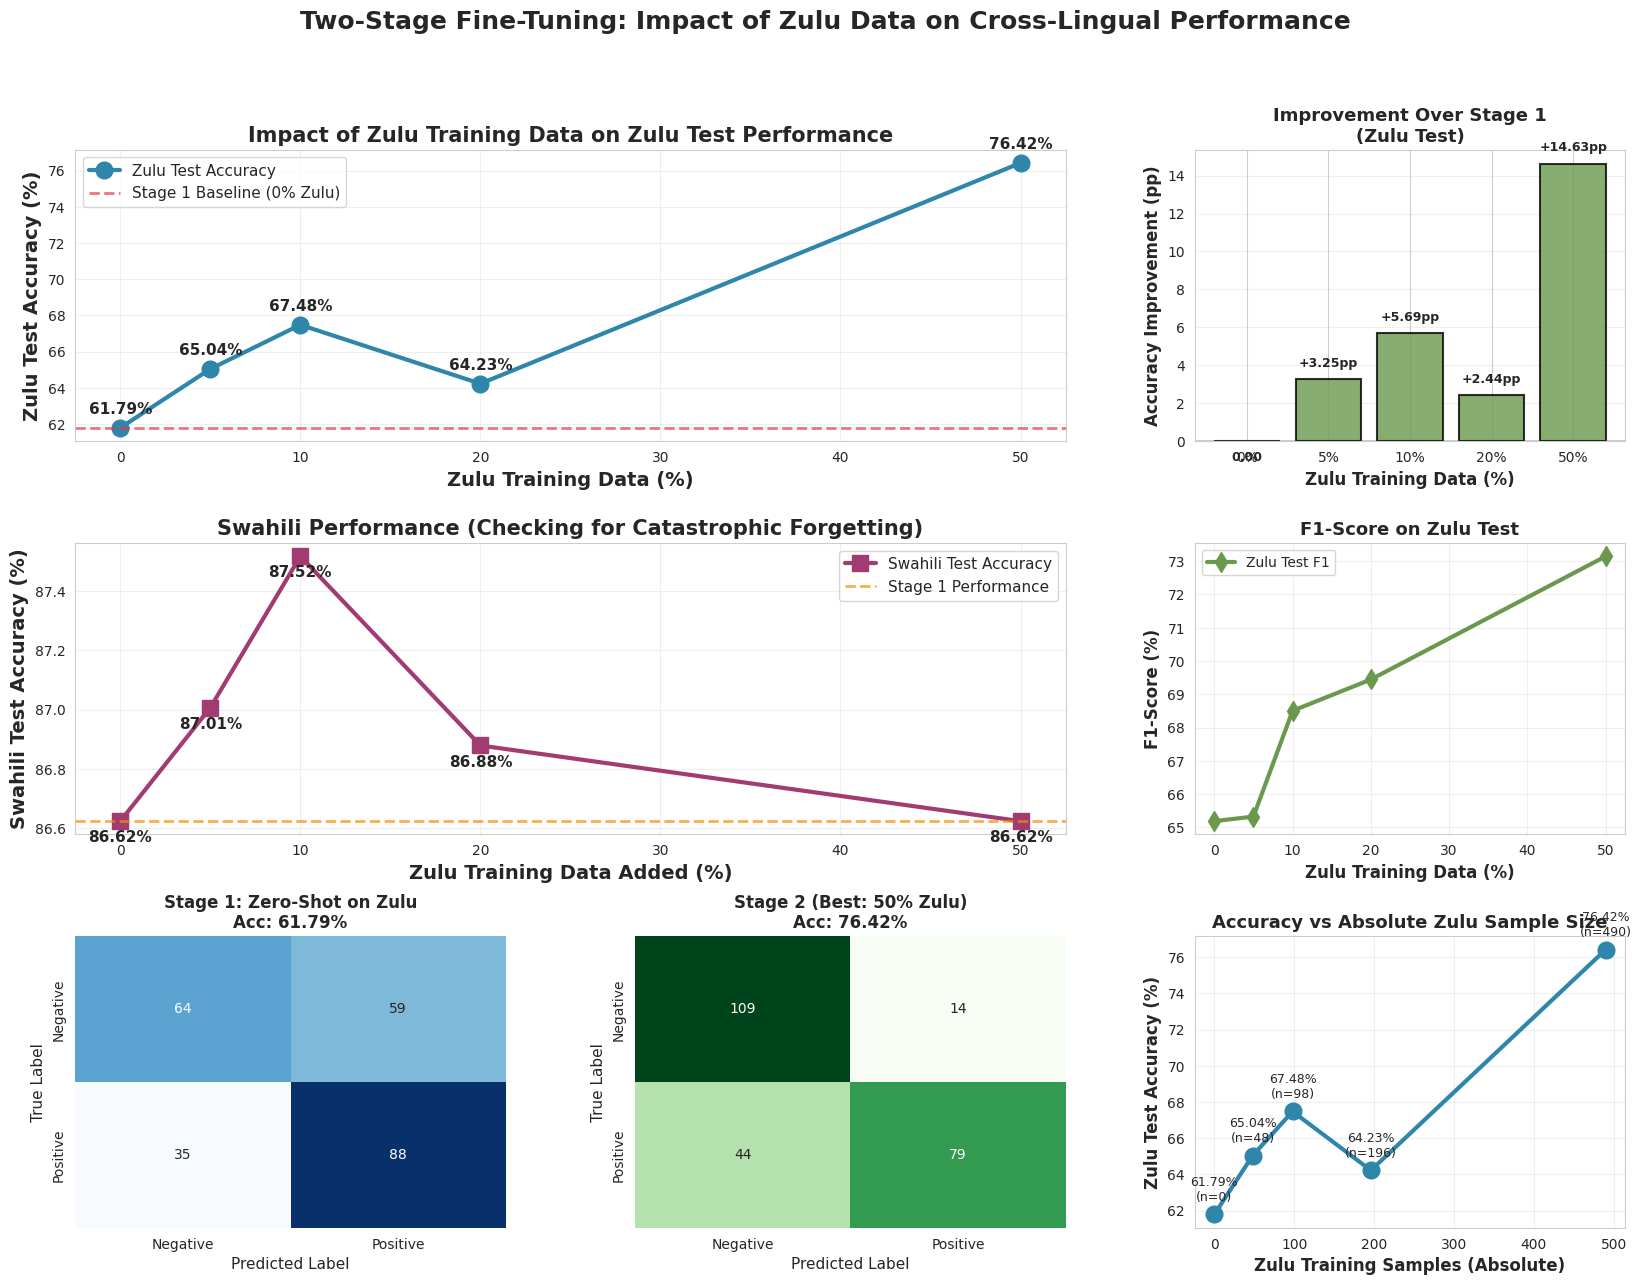

✅ Detailed metrics graph saved: 'detailed_metrics_comparison.png'


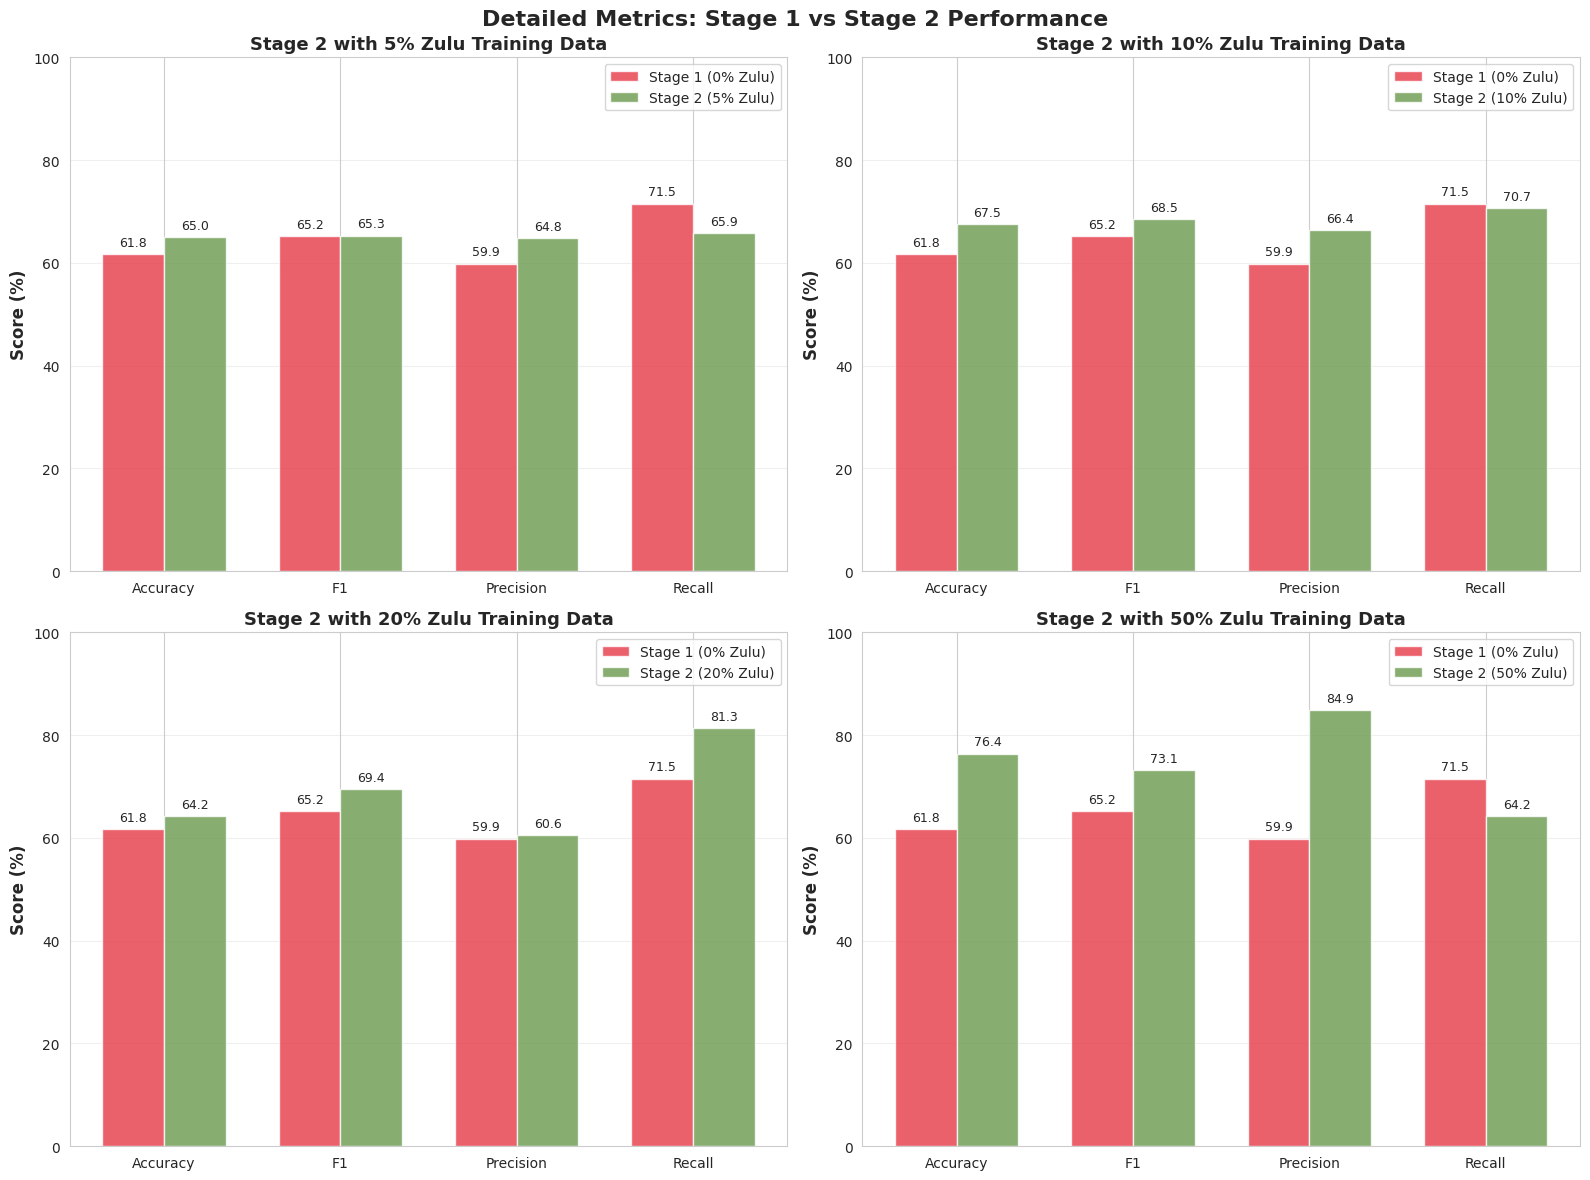


💾 SAVING RESULTS
✅ Summary saved to: 'two_stage_finetuning_summary.csv'
✅ Report saved to: 'experiment_report.txt'

🎉 TWO-STAGE FINE-TUNING EXPERIMENT COMPLETE!

📊 QUICK SUMMARY:

🔵 Stage 1 (Swahili Only - Zero-Shot on Zulu):
  • Zulu test accuracy: 61.79%
  • Swahili test accuracy: 86.62%

🟢 Stage 2 Results:
  • 5% Zulu (48 samples): 65.04% (improvement: +3.25pp)
  • 10% Zulu (98 samples): 67.48% (improvement: +5.69pp)
  • 20% Zulu (196 samples): 64.23% (improvement: +2.44pp)
  • 50% Zulu (490 samples): 76.42% (improvement: +14.63pp)

⭐ Best performance: 50% Zulu training data

📁 Generated Files:
  • two_stage_finetuning_results.png (main visualization)
  • detailed_metrics_comparison.png (detailed metrics)
  • two_stage_finetuning_summary.csv (all results)
  • experiment_report.txt (text summary)
  • ./stage1_swahili_only/ (Stage 1 model)
  • ./stage2_swahili_zulu_5pct/ (Stage 2 model with 5% Zulu)
  • ./stage2_swahili_zulu_10pct/ (Stage 2 model with 10% Zulu)
  • ./stage2_swahili_z

In [ ]:
"""
Two-Stage Fine-Tuning for Cross-Lingual Transfer
Stage 1: Train on Swahili only
Stage 2: Fine-tune on Swahili + small portion of Zulu
Test: Evaluate on full Zulu test set
"""

# ============================================================================
# Step 0: Install & Import Dependencies
# ============================================================================
print("="*80)
print("📦 INSTALLING DEPENDENCIES")
print("="*80)

!pip install -q transformers torch scikit-learn pandas datasets accelerate openpyxl matplotlib seaborn

import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
import json
import os
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
print()

# ============================================================================
# Configuration
# ============================================================================
class Config:
    MODEL_NAME = "Davlan/afro-xlmr-base"
    MAX_LENGTH = 128
    BATCH_SIZE = 16
    LEARNING_RATE_STAGE1 = 2e-5
    LEARNING_RATE_STAGE2 = 1e-5  # Lower LR for fine-tuning
    EPOCHS_STAGE1 = 5
    EPOCHS_STAGE2 = 3
    WARMUP_STEPS = 100
    WEIGHT_DECAY = 0.01
    SEED = 42

    # Percentage of Zulu training data to use in Stage 2
    ZULU_PERCENTAGES = [5, 10, 20, 50]  # Test different amounts

    # Binary Label mappings
    ID2LABEL = {0: 'negative', 1: 'positive'}
    LABEL2ID = {'negative': 0, 'positive': 1}
    NUM_LABELS = 2

torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

print("="*80)
print("🎓 TWO-STAGE FINE-TUNING EXPERIMENT")
print("="*80)
print("Stage 1: Train on Swahili only")
print("Stage 2: Fine-tune on Swahili + varying amounts of Zulu")
print("Test: Evaluate on full Zulu test set")
print("="*80)
print()

# ============================================================================
# Helper Functions
# ============================================================================

def standardize_binary_label(label):
    """Convert various label formats to binary 0/1"""
    label = str(label).strip().lower()
    if 'neg' in label or label == '0':
        return 0
    elif 'pos' in label or label == '1' or label == '2':
        return 1
    else:
        return None  # Neutral or unknown

def load_and_prepare_data(file_path, text_col_names=['text', 'Zulu'],
                          label_col_names=['label', 'new_sentiment', 'sentiment']):
    """Load data from CSV/Excel and standardize format"""
    # Load file
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        df = pd.read_excel(file_path)

    print(f"✅ Loaded: {len(df)} rows")
    print(f"Columns: {list(df.columns)}")

    # Find text column
    text_col = None
    for col in text_col_names:
        if col in df.columns:
            text_col = col
            break
    if text_col is None:
        text_candidates = [col for col in df.columns if 'text' in col.lower() or 'tweet' in col.lower()]
        if text_candidates:
            text_col = text_candidates[0]

    if text_col != 'text':
        df = df.rename(columns={text_col: 'text'})
        print(f"✅ Renamed '{text_col}' to 'text'")

    # Find label column
    label_col = None
    for col in label_col_names:
        if col in df.columns:
            label_col = col
            break
    if label_col is None:
        label_candidates = [col for col in df.columns if 'label' in col.lower() or 'sentiment' in col.lower()]
        if label_candidates:
            label_col = label_candidates[0]

    if label_col != 'label':
        df = df.rename(columns={label_col: 'label'})
        print(f"✅ Renamed '{label_col}' to 'label'")

    # Standardize labels
    df['label'] = df['label'].apply(standardize_binary_label)

    # Remove neutral/invalid
    neutral_count = df['label'].isna().sum()
    df = df[['text', 'label']].dropna()
    df = df[df['label'].isin([0, 1])]
    df['label'] = df['label'].astype(int)

    print(f"✅ After cleaning: {len(df)} samples (removed {neutral_count} neutral/invalid)")
    print(f"\nLabel distribution:")
    for i, label_name in enumerate(['negative', 'positive']):
        count = (df['label'] == i).sum()
        pct = count / len(df) * 100
        print(f"  {i} ({label_name}): {count} ({pct:.1f}%)")

    return df

def tokenize_function(examples, tokenizer):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=Config.MAX_LENGTH
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def evaluate_model(trainer, dataset, dataset_name):
    """Evaluate model and return detailed results"""
    print(f"\n📊 Evaluating on {dataset_name}...")

    results = trainer.evaluate(dataset)
    predictions = trainer.predict(dataset)
    pred_labels = predictions.predictions.argmax(-1)
    true_labels = predictions.label_ids

    # Get probabilities
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Per-class metrics
    class_metrics = {}
    for i, label_name in enumerate(['negative', 'positive']):
        mask = true_labels == i
        if mask.sum() > 0:
            class_acc = (pred_labels[mask] == true_labels[mask]).sum() / mask.sum()
            class_metrics[label_name] = {
                'accuracy': class_acc,
                'count': mask.sum()
            }

    print(f"\n{dataset_name} Results:")
    print(f"  Accuracy:  {results['eval_accuracy']:.4f} ({results['eval_accuracy']*100:.2f}%)")
    print(f"  F1-Score:  {results['eval_f1']:.4f}")
    print(f"  Precision: {results['eval_precision']:.4f}")
    print(f"  Recall:    {results['eval_recall']:.4f}")

    return {
        'results': results,
        'predictions': pred_labels,
        'true_labels': true_labels,
        'probabilities': probs,
        'confusion_matrix': cm,
        'class_metrics': class_metrics
    }

# ============================================================================
# Step 1: Load Swahili Dataset
# ============================================================================
print("="*80)
print("📤 STEP 1: Upload SWAHILI training data")
print("="*80)
print("Expected: CSV/Excel with 'text' and 'label' columns")
print("Labels should be negative/positive (neutral will be removed)")
print("="*80)

uploaded_swahili = files.upload()
swahili_file = list(uploaded_swahili.keys())[0]

print(f"\n📂 Loading Swahili data from: {swahili_file}")
swahili_df = load_and_prepare_data(swahili_file)

# Split Swahili: 70% train, 10% val, 20% test
swahili_train_val, swahili_test = train_test_split(
    swahili_df, test_size=0.2, random_state=Config.SEED, stratify=swahili_df['label']
)
swahili_train, swahili_val = train_test_split(
    swahili_train_val, test_size=0.125, random_state=Config.SEED,
    stratify=swahili_train_val['label']
)

print(f"\n✂️  Swahili split:")
print(f"  Training:   {len(swahili_train)} samples")
print(f"  Validation: {len(swahili_val)} samples")
print(f"  Test:       {len(swahili_test)} samples")

# ============================================================================
# Step 2: Load Zulu Dataset (will be split into train and test)
# ============================================================================
print("\n" + "="*80)
print("📤 STEP 2: Upload ZULU data")
print("="*80)
print("This will be automatically split: 80% for Stage 2 fine-tuning, 20% for testing")
print("="*80)

uploaded_zulu = files.upload()
zulu_file = list(uploaded_zulu.keys())[0]

print(f"\n📂 Loading Zulu data from: {zulu_file}")
zulu_full_df = load_and_prepare_data(zulu_file)

# Split Zulu: 80% for training (Stage 2), 20% for testing
zulu_train_full_df, zulu_test_df = train_test_split(
    zulu_full_df,
    test_size=0.2,
    random_state=Config.SEED,
    stratify=zulu_full_df['label']
)

print(f"\n✂️  Zulu split:")
print(f"  Training pool: {len(zulu_train_full_df)} samples (80% - for Stage 2 fine-tuning)")
print(f"  Test set:      {len(zulu_test_df)} samples (20% - held out for evaluation)")

print(f"\nZulu training pool label distribution:")
for i, label_name in enumerate(['negative', 'positive']):
    count = (zulu_train_full_df['label'] == i).sum()
    pct = count / len(zulu_train_full_df) * 100
    print(f"  {i} ({label_name}): {count} ({pct:.1f}%)")

print(f"\nZulu test set label distribution:")
for i, label_name in enumerate(['negative', 'positive']):
    count = (zulu_test_df['label'] == i).sum()
    pct = count / len(zulu_test_df) * 100
    print(f"  {i} ({label_name}): {count} ({pct:.1f}%)")

# ============================================================================
# Step 3: Prepare Tokenizer and Base Datasets
# ============================================================================
print("\n" + "="*80)
print("🔤 TOKENIZING DATASETS")
print("="*80)

tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

# Tokenize Swahili datasets
swahili_train_dataset = Dataset.from_pandas(swahili_train).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)
swahili_val_dataset = Dataset.from_pandas(swahili_val).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)
swahili_test_dataset = Dataset.from_pandas(swahili_test).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)

# Tokenize Zulu test dataset
zulu_test_dataset = Dataset.from_pandas(zulu_test_df).map(
    lambda x: tokenize_function(x, tokenizer), batched=True
)

print("✅ Base datasets tokenized")

# ============================================================================
# STAGE 1: Train on Swahili Only
# ============================================================================
print("\n" + "="*80)
print("🚀 STAGE 1: TRAINING ON SWAHILI ONLY")
print("="*80)

# Load fresh model
stage1_model = AutoModelForSequenceClassification.from_pretrained(
    Config.MODEL_NAME,
    num_labels=Config.NUM_LABELS,
    id2label=Config.ID2LABEL,
    label2id=Config.LABEL2ID
)
stage1_model.to(device)

print(f"✅ Model loaded: {Config.MODEL_NAME}")

# Training arguments for Stage 1
stage1_training_args = TrainingArguments(
    output_dir="./stage1_swahili_only",
    num_train_epochs=Config.EPOCHS_STAGE1,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    warmup_steps=Config.WARMUP_STEPS,
    weight_decay=Config.WEIGHT_DECAY,
    learning_rate=Config.LEARNING_RATE_STAGE1,
    logging_dir='./stage1_swahili_only/logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
    seed=Config.SEED
)

# Create trainer for Stage 1
stage1_trainer = Trainer(
    model=stage1_model,
    args=stage1_training_args,
    train_dataset=swahili_train_dataset,
    eval_dataset=swahili_val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print(f"\n🏋️  Training Stage 1 (Swahili only, {Config.EPOCHS_STAGE1} epochs)...")
stage1_trainer.train()
print(f"✅ Stage 1 training complete!\n")

# Evaluate Stage 1
print("\n" + "="*80)
print("📊 STAGE 1 EVALUATION")
print("="*80)

stage1_on_swahili = evaluate_model(stage1_trainer, swahili_test_dataset,
                                   "Stage 1 → Swahili Test")
stage1_on_zulu = evaluate_model(stage1_trainer, zulu_test_dataset,
                               "Stage 1 → Zulu Test (Zero-Shot)")

# Save Stage 1 model
stage1_trainer.save_model("./stage1_swahili_only")
tokenizer.save_pretrained("./stage1_swahili_only")
print("\n💾 Stage 1 model saved")

# ============================================================================
# STAGE 2: Fine-tune on Swahili + Various Portions of Zulu
# ============================================================================
print("\n" + "="*80)
print("🚀 STAGE 2: FINE-TUNING WITH SWAHILI + ZULU")
print("="*80)
print(f"Testing with Zulu percentages: {Config.ZULU_PERCENTAGES}")
print("="*80)

stage2_results = {}

for zulu_pct in Config.ZULU_PERCENTAGES:
    print("\n" + "="*80)
    print(f"📊 STAGE 2: Training with {zulu_pct}% Zulu data")
    print("="*80)

    # Sample Zulu training data
    zulu_sample_size = int(len(zulu_train_full_df) * (zulu_pct / 100))

    # Stratified sampling from Zulu
    zulu_train_sample = zulu_train_full_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(frac=zulu_pct/100, random_state=Config.SEED)
    ).reset_index(drop=True)

    print(f"\n📦 Stage 2 training data:")
    print(f"  Swahili: {len(swahili_train)} samples (100%)")
    print(f"  Zulu:    {len(zulu_train_sample)} samples ({zulu_pct}%)")
    print(f"  Total:   {len(swahili_train) + len(zulu_train_sample)} samples")

    # Combine Swahili and Zulu
    stage2_train_df = pd.concat([swahili_train, zulu_train_sample], ignore_index=True)

    # Shuffle
    stage2_train_df = stage2_train_df.sample(frac=1, random_state=Config.SEED).reset_index(drop=True)

    print(f"\nStage 2 combined label distribution:")
    for i, label_name in enumerate(['negative', 'positive']):
        count = (stage2_train_df['label'] == i).sum()
        pct = count / len(stage2_train_df) * 100
        print(f"  {i} ({label_name}): {count} ({pct:.1f}%)")

    # Tokenize Stage 2 training data
    stage2_train_dataset = Dataset.from_pandas(stage2_train_df).map(
        lambda x: tokenize_function(x, tokenizer), batched=True
    )

    # Load Stage 1 model for fine-tuning
    print(f"\n🔄 Loading Stage 1 model for fine-tuning...")
    stage2_model = AutoModelForSequenceClassification.from_pretrained(
        "./stage1_swahili_only",
        num_labels=Config.NUM_LABELS,
        id2label=Config.ID2LABEL,
        label2id=Config.LABEL2ID
    )
    stage2_model.to(device)

    # Training arguments for Stage 2
    save_dir = f"./stage2_swahili_zulu_{zulu_pct}pct"
    stage2_training_args = TrainingArguments(
        output_dir=save_dir,
        num_train_epochs=Config.EPOCHS_STAGE2,
        per_device_train_batch_size=Config.BATCH_SIZE,
        per_device_eval_batch_size=Config.BATCH_SIZE,
        warmup_steps=50,
        weight_decay=Config.WEIGHT_DECAY,
        learning_rate=Config.LEARNING_RATE_STAGE2,  # Lower LR for fine-tuning
        logging_dir=f'{save_dir}/logs',
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=2,
        report_to="none",
        seed=Config.SEED
    )

    # Create trainer for Stage 2
    stage2_trainer = Trainer(
        model=stage2_model,
        args=stage2_training_args,
        train_dataset=stage2_train_dataset,
        eval_dataset=swahili_val_dataset,  # Validate on Swahili
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    print(f"\n🏋️  Fine-tuning Stage 2 ({zulu_pct}% Zulu, {Config.EPOCHS_STAGE2} epochs)...")
    stage2_trainer.train()
    print(f"✅ Stage 2 fine-tuning complete for {zulu_pct}% Zulu!\n")

    # Evaluate Stage 2
    print(f"\n📊 Evaluating Stage 2 ({zulu_pct}% Zulu)...")

    stage2_on_swahili = evaluate_model(stage2_trainer, swahili_test_dataset,
                                       f"Stage 2 ({zulu_pct}% Zulu) → Swahili Test")
    stage2_on_zulu = evaluate_model(stage2_trainer, zulu_test_dataset,
                                    f"Stage 2 ({zulu_pct}% Zulu) → Zulu Test")

    # Save results
    stage2_results[zulu_pct] = {
        'on_swahili': stage2_on_swahili,
        'on_zulu': stage2_on_zulu,
        'zulu_samples': len(zulu_train_sample)
    }

    # Save Stage 2 model
    stage2_trainer.save_model(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"\n💾 Stage 2 model ({zulu_pct}% Zulu) saved to: {save_dir}\n")

    # Clean up
    del stage2_model
    del stage2_trainer
    torch.cuda.empty_cache()

# ============================================================================
# Step 4: Create Comprehensive Visualizations
# ============================================================================
print("\n" + "="*80)
print("📊 CREATING VISUALIZATIONS")
print("="*80)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 14)

# Create main figure
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

fig.suptitle('Two-Stage Fine-Tuning: Impact of Zulu Data on Cross-Lingual Performance',
             fontsize=18, fontweight='bold', y=0.98)

# ============================================================================
# Plot 1: Zulu Test Accuracy vs Zulu Training Percentage
# ============================================================================
ax1 = fig.add_subplot(gs[0, :2])

zulu_percentages = [0] + Config.ZULU_PERCENTAGES  # Add 0 for Stage 1
zulu_test_accs = [stage1_on_zulu['results']['eval_accuracy'] * 100]
zulu_test_accs += [stage2_results[pct]['on_zulu']['results']['eval_accuracy'] * 100
                   for pct in Config.ZULU_PERCENTAGES]

ax1.plot(zulu_percentages, zulu_test_accs, marker='o', linewidth=3,
         markersize=12, color='#2E86AB', label='Zulu Test Accuracy')
ax1.axhline(y=stage1_on_zulu['results']['eval_accuracy'] * 100,
           color='#E63946', linestyle='--', linewidth=2,
           label='Stage 1 Baseline (0% Zulu)', alpha=0.7)
ax1.set_xlabel('Zulu Training Data (%)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Zulu Test Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Impact of Zulu Training Data on Zulu Test Performance',
             fontsize=15, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

for x, y in zip(zulu_percentages, zulu_test_accs):
    ax1.annotate(f'{y:.2f}%', (x, y), textcoords="offset points",
                xytext=(0,10), ha='center', fontsize=11, fontweight='bold')

# ============================================================================
# Plot 2: Improvement Over Stage 1
# ============================================================================
ax2 = fig.add_subplot(gs[0, 2])

improvements = [0]  # Stage 1 baseline
improvements += [(stage2_results[pct]['on_zulu']['results']['eval_accuracy'] -
                  stage1_on_zulu['results']['eval_accuracy']) * 100
                 for pct in Config.ZULU_PERCENTAGES]

colors_improvement = ['#E63946' if imp < 0 else '#6A994E' for imp in improvements]
bars = ax2.bar(range(len(zulu_percentages)), improvements,
              color=colors_improvement, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Zulu Training Data (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy Improvement (pp)', fontsize=12, fontweight='bold')
ax2.set_title('Improvement Over Stage 1\n(Zulu Test)', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(zulu_percentages)))
ax2.set_xticklabels([f'{p}%' for p in zulu_percentages])
ax2.grid(axis='y', alpha=0.3)

for bar, imp in zip(bars, improvements):
    height = bar.get_height()
    label = f'{imp:+.2f}pp' if imp != 0 else '0.00'
    ax2.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -0.5),
            label, ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9, fontweight='bold')

# ============================================================================
# Plot 3: Swahili Test Accuracy (Check for Catastrophic Forgetting)
# ============================================================================
ax3 = fig.add_subplot(gs[1, :2])

swahili_test_accs = [stage1_on_swahili['results']['eval_accuracy'] * 100]
swahili_test_accs += [stage2_results[pct]['on_swahili']['results']['eval_accuracy'] * 100
                      for pct in Config.ZULU_PERCENTAGES]

ax3.plot(zulu_percentages, swahili_test_accs, marker='s', linewidth=3,
         markersize=12, color='#A23B72', label='Swahili Test Accuracy')
ax3.axhline(y=stage1_on_swahili['results']['eval_accuracy'] * 100,
           color='#F18F01', linestyle='--', linewidth=2,
           label='Stage 1 Performance', alpha=0.7)
ax3.set_xlabel('Zulu Training Data Added (%)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Swahili Test Accuracy (%)', fontsize=14, fontweight='bold')
ax3.set_title('Swahili Performance (Checking for Catastrophic Forgetting)',
             fontsize=15, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=11)

for x, y in zip(zulu_percentages, swahili_test_accs):
    ax3.annotate(f'{y:.2f}%', (x, y), textcoords="offset points",
                xytext=(0,-15), ha='center', fontsize=11, fontweight='bold')

# ============================================================================
# Plot 4: F1-Score Comparison
# ============================================================================
ax4 = fig.add_subplot(gs[1, 2])

zulu_f1_scores = [stage1_on_zulu['results']['eval_f1'] * 100]
zulu_f1_scores += [stage2_results[pct]['on_zulu']['results']['eval_f1'] * 100
                   for pct in Config.ZULU_PERCENTAGES]

ax4.plot(zulu_percentages, zulu_f1_scores, marker='d', linewidth=3,
         markersize=10, color='#6A994E', label='Zulu Test F1')
ax4.set_xlabel('Zulu Training Data (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('F1-Score (%)', fontsize=12, fontweight='bold')
ax4.set_title('F1-Score on Zulu Test', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)

# ============================================================================
# Plot 5: Confusion Matrix - Stage 1 (Zero-Shot)
# ============================================================================
ax5 = fig.add_subplot(gs[2, 0])
cm1 = stage1_on_zulu['confusion_matrix']
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax5,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
ax5.set_title(f'Stage 1: Zero-Shot on Zulu\nAcc: {stage1_on_zulu["results"]["eval_accuracy"]*100:.2f}%',
             fontsize=12, fontweight='bold')
ax5.set_ylabel('True Label', fontsize=11)
ax5.set_xlabel('Predicted Label', fontsize=11)

# ============================================================================
# Plot 6: Confusion Matrix - Best Stage 2
# ============================================================================
ax6 = fig.add_subplot(gs[2, 1])
best_pct = max(Config.ZULU_PERCENTAGES,
               key=lambda p: stage2_results[p]['on_zulu']['results']['eval_accuracy'])
cm_best = stage2_results[best_pct]['on_zulu']['confusion_matrix']
best_acc = stage2_results[best_pct]['on_zulu']['results']['eval_accuracy']
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax6,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
ax6.set_title(f'Stage 2 (Best: {best_pct}% Zulu)\nAcc: {best_acc*100:.2f}%',
             fontsize=12, fontweight='bold')
ax6.set_ylabel('True Label', fontsize=11)
ax6.set_xlabel('Predicted Label', fontsize=11)

# ============================================================================
# Plot 7: Training Data Size vs Performance
# ============================================================================
ax7 = fig.add_subplot(gs[2, 2])

zulu_sample_sizes = [0] + [stage2_results[pct]['zulu_samples'] for pct in Config.ZULU_PERCENTAGES]
ax7.plot(zulu_sample_sizes, zulu_test_accs, marker='o', linewidth=3,
         markersize=12, color='#2E86AB')
ax7.set_xlabel('Zulu Training Samples (Absolute)', fontsize=12, fontweight='bold')
ax7.set_ylabel('Zulu Test Accuracy (%)', fontsize=12, fontweight='bold')
ax7.set_title('Accuracy vs Absolute Zulu Sample Size', fontsize=13, fontweight='bold')
ax7.grid(True, alpha=0.3)

for x, y in zip(zulu_sample_sizes, zulu_test_accs):
    ax7.annotate(f'{y:.2f}%\n(n={x})', (x, y), textcoords="offset points",
                xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('two_stage_finetuning_results.png', dpi=300, bbox_inches='tight')
print("✅ Main results graph saved: 'two_stage_finetuning_results.png'")
plt.show()

# ============================================================================
# Additional Plot: Detailed Metrics Comparison
# ============================================================================
fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('Detailed Metrics: Stage 1 vs Stage 2 Performance',
              fontsize=16, fontweight='bold')

# All metrics for Zulu test
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
stage1_metrics = [
    stage1_on_zulu['results']['eval_accuracy'] * 100,
    stage1_on_zulu['results']['eval_f1'] * 100,
    stage1_on_zulu['results']['eval_precision'] * 100,
    stage1_on_zulu['results']['eval_recall'] * 100
]

for idx, pct in enumerate(Config.ZULU_PERCENTAGES):
    ax = axes[idx // 2, idx % 2]

    stage2_metrics = [
        stage2_results[pct]['on_zulu']['results']['eval_accuracy'] * 100,
        stage2_results[pct]['on_zulu']['results']['eval_f1'] * 100,
        stage2_results[pct]['on_zulu']['results']['eval_precision'] * 100,
        stage2_results[pct]['on_zulu']['results']['eval_recall'] * 100
    ]

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = ax.bar(x - width/2, stage1_metrics, width,
                   label='Stage 1 (0% Zulu)', color='#E63946', alpha=0.8)
    bars2 = ax.bar(x + width/2, stage2_metrics, width,
                   label=f'Stage 2 ({pct}% Zulu)', color='#6A994E', alpha=0.8)

    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Stage 2 with {pct}% Zulu Training Data', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend(fontsize=10)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('detailed_metrics_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Detailed metrics graph saved: 'detailed_metrics_comparison.png'")
plt.show()

# ============================================================================
# Step 5: Save Results Summary
# ============================================================================
print("\n" + "="*80)
print("💾 SAVING RESULTS")
print("="*80)

# Create summary dataframe
summary_data = []

# Stage 1
summary_data.append({
    'Stage': 1,
    'Zulu_Train_Pct': 0,
    'Zulu_Train_Samples': 0,
    'Swahili_Test_Acc': stage1_on_swahili['results']['eval_accuracy'],
    'Swahili_Test_F1': stage1_on_swahili['results']['eval_f1'],
    'Zulu_Test_Acc': stage1_on_zulu['results']['eval_accuracy'],
    'Zulu_Test_F1': stage1_on_zulu['results']['eval_f1']
})

# Stage 2
for pct in Config.ZULU_PERCENTAGES:
    summary_data.append({
        'Stage': 2,
        'Zulu_Train_Pct': pct,
        'Zulu_Train_Samples': stage2_results[pct]['zulu_samples'],
        'Swahili_Test_Acc': stage2_results[pct]['on_swahili']['results']['eval_accuracy'],
        'Swahili_Test_F1': stage2_results[pct]['on_swahili']['results']['eval_f1'],
        'Zulu_Test_Acc': stage2_results[pct]['on_zulu']['results']['eval_accuracy'],
        'Zulu_Test_F1': stage2_results[pct]['on_zulu']['results']['eval_f1']
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('two_stage_finetuning_summary.csv', index=False)
print("✅ Summary saved to: 'two_stage_finetuning_summary.csv'")

# Save detailed text summary
with open('experiment_report.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("TWO-STAGE FINE-TUNING EXPERIMENT REPORT\n")
    f.write("="*80 + "\n\n")

    f.write("EXPERIMENTAL DESIGN:\n")
    f.write(f"- Model: {Config.MODEL_NAME}\n")
    f.write(f"- Task: Binary sentiment classification (negative vs positive)\n")
    f.write(f"- Stage 1: Train on Swahili only ({len(swahili_train)} samples)\n")
    f.write(f"- Stage 2: Fine-tune on Swahili + varying Zulu amounts\n")
    f.write(f"- Test: Zulu test set ({len(zulu_test_df)} samples)\n\n")

    f.write("RESULTS:\n\n")
    f.write(summary_df.to_string(index=False))
    f.write("\n\n")

    f.write("KEY FINDINGS:\n")
    f.write(f"1. Stage 1 (Zero-Shot):\n")
    f.write(f"   - Zulu test accuracy: {stage1_on_zulu['results']['eval_accuracy']*100:.2f}%\n")
    f.write(f"   - Swahili test accuracy: {stage1_on_swahili['results']['eval_accuracy']*100:.2f}%\n\n")

    best_pct = max(Config.ZULU_PERCENTAGES,
                   key=lambda p: stage2_results[p]['on_zulu']['results']['eval_accuracy'])
    best_acc = stage2_results[best_pct]['on_zulu']['results']['eval_accuracy'] * 100
    improvement = (stage2_results[best_pct]['on_zulu']['results']['eval_accuracy'] -
                   stage1_on_zulu['results']['eval_accuracy']) * 100

    f.write(f"2. Best Stage 2 Performance ({best_pct}% Zulu):\n")
    f.write(f"   - Zulu test accuracy: {best_acc:.2f}%\n")
    f.write(f"   - Improvement over Stage 1: +{improvement:.2f}pp\n")
    f.write(f"   - Zulu samples used: {stage2_results[best_pct]['zulu_samples']}\n\n")

    f.write(f"3. Catastrophic Forgetting Check:\n")
    swahili_drop = (stage1_on_swahili['results']['eval_accuracy'] -
                    stage2_results[best_pct]['on_swahili']['results']['eval_accuracy']) * 100
    f.write(f"   - Swahili accuracy drop: {swahili_drop:.2f}pp\n")
    if abs(swahili_drop) < 2:
        f.write(f"   ✅ No significant forgetting\n")
    elif abs(swahili_drop) < 5:
        f.write(f"   ⚠️  Minor forgetting\n")
    else:
        f.write(f"   ⚠️  Significant forgetting detected\n")

print("✅ Report saved to: 'experiment_report.txt'")

# ============================================================================
# Step 6: Final Summary
# ============================================================================
print("\n" + "="*80)
print("🎉 TWO-STAGE FINE-TUNING EXPERIMENT COMPLETE!")
print("="*80)

print("\n📊 QUICK SUMMARY:")
print(f"\n🔵 Stage 1 (Swahili Only - Zero-Shot on Zulu):")
print(f"  • Zulu test accuracy: {stage1_on_zulu['results']['eval_accuracy']*100:.2f}%")
print(f"  • Swahili test accuracy: {stage1_on_swahili['results']['eval_accuracy']*100:.2f}%")

print(f"\n🟢 Stage 2 Results:")
for pct in Config.ZULU_PERCENTAGES:
    zulu_acc = stage2_results[pct]['on_zulu']['results']['eval_accuracy'] * 100
    improvement = (stage2_results[pct]['on_zulu']['results']['eval_accuracy'] -
                   stage1_on_zulu['results']['eval_accuracy']) * 100
    print(f"  • {pct}% Zulu ({stage2_results[pct]['zulu_samples']} samples): "
          f"{zulu_acc:.2f}% (improvement: {improvement:+.2f}pp)")

best_pct = max(Config.ZULU_PERCENTAGES,
               key=lambda p: stage2_results[p]['on_zulu']['results']['eval_accuracy'])
print(f"\n⭐ Best performance: {best_pct}% Zulu training data")

print("\n📁 Generated Files:")
print("  • two_stage_finetuning_results.png (main visualization)")
print("  • detailed_metrics_comparison.png (detailed metrics)")
print("  • two_stage_finetuning_summary.csv (all results)")
print("  • experiment_report.txt (text summary)")
print("  • ./stage1_swahili_only/ (Stage 1 model)")
for pct in Config.ZULU_PERCENTAGES:
    print(f"  • ./stage2_swahili_zulu_{pct}pct/ (Stage 2 model with {pct}% Zulu)")

print("\n" + "="*80)
print("Done! 🎉")
print("="*80)

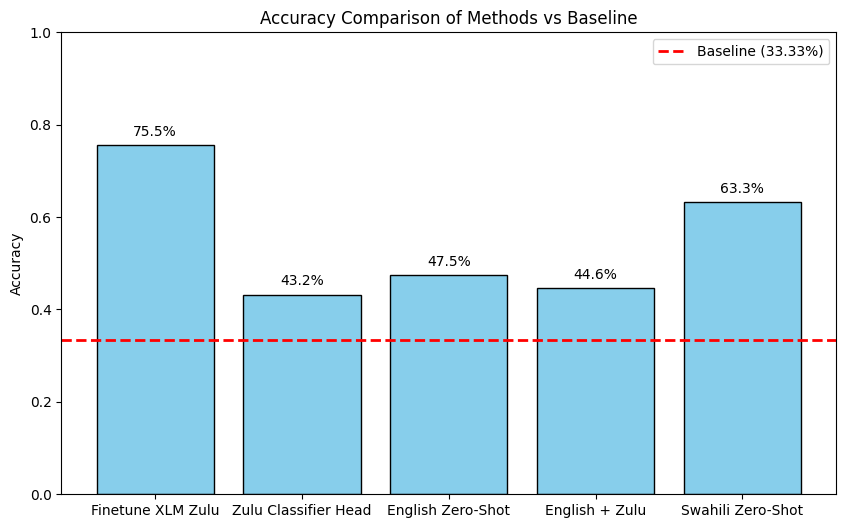

In [1]:
import matplotlib.pyplot as plt

# Methods
methods = [
    "Finetune XLM Zulu",
    "Zulu Classifier Head",
    "English Zero-Shot",
    "English + Zulu",
    "Swahili Zero-Shot"
]

# Accuracies
accuracies = [
    0.7554,   # Finetune XLM Zulu
    0.4321,   # Zulu Classifier Head
    0.4753,   # English Zero-Shot
    0.4457,   # English + Zulu
    0.6330    # Swahili Zero-Shot
]

baseline = 0.3333  # 1/3

# Create bar chart
plt.figure(figsize=(10,6))
bars = plt.bar(methods, accuracies, color='skyblue', edgecolor='black')

# Add baseline line
plt.axhline(y=baseline, color='red', linestyle='--', linewidth=2, label='Baseline (33.33%)')

# Add accuracy labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.02, f"{acc*100:.1f}%", ha='center', fontsize=10)

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Methods vs Baseline")
plt.legend()
plt.show()


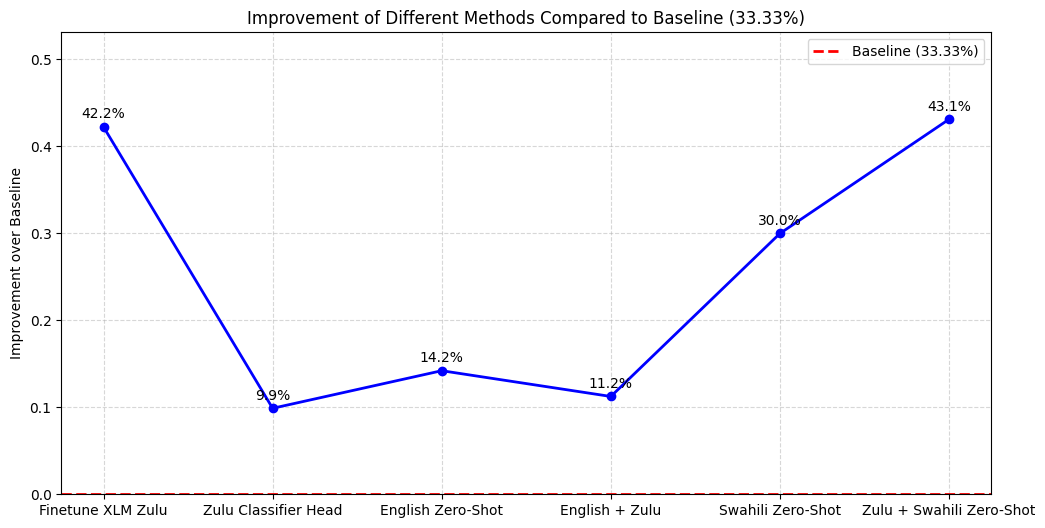

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Methods
methods = [
    "Finetune XLM Zulu",
    "Zulu Classifier Head",
    "English Zero-Shot",
    "English + Zulu",
    "Swahili Zero-Shot",
    "Zulu + Swahili Zero-Shot"
]

# Accuracies
accuracies = np.array([
    0.7554,   # Finetune XLM Zulu
    0.4321,   # Zulu Classifier Head
    0.4753,   # English Zero-Shot
    0.4457,   # English + Zulu
    0.6330,   # Swahili Zero-Shot
    0.7642    # Zulu + Swahili Zero-Shot
])

baseline = 0.3333  # 33.33%

# Compute improvement over baseline
improvement = accuracies - baseline

# Create line plot
plt.figure(figsize=(12,6))
plt.plot(methods, improvement, marker='o', linestyle='-', color='blue', linewidth=2)

# Add baseline line at zero
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Baseline (33.33%)')

# Annotate improvement values
for i, imp in enumerate(improvement):
    plt.text(i, imp + 0.01, f"{imp*100:.1f}%", ha='center', fontsize=10)

plt.ylabel("Improvement over Baseline")
plt.title("Improvement of Different Methods Compared to Baseline (33.33%)")
plt.ylim(0, max(improvement) + 0.1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
